# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from typing import *
import scipy.stats as scistat
from scipy import special
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
import pymysql

# **Class and Functional Programming**

In [2]:
# Class Programming for Calc and Printing Mean and Standard Deviation
class StatsSummary:
    """Prints statistic summary (*mean*, *std*, *median*)
    
    ### **Parameter:**
    `data`
    - `DataFrame`, `dict`, or `array` type
    - the data to get its statistic summary
    -----------
    ### **Methods**

    **`print_stats()`**
        - prints statistic summary

    **`<class var>.data`**
        - get data
    **`<class var>.mean`**
        - get mean of data

    **`<class var>.median`**
        - get median of data

    **`<class var>.std`**
        - get standard deviation of data

    **`<class var>.stats`**
        - get dictionary of statistic summary"""

    def __init__(self, data) -> None:                           #<- Instantiation
        self.data = data                                        #<- Data
        self.stat_summary = data.describe()                     #<- Count, mean, std, min, 25%, 50%, 75%, max
        self.mean = np.mean(data)                               #<- Mean
        self.median = np.median(data)                           #<- Median
        self.std = np.std(data, ddof=1)                         #<- Std (1 degree of freedom)
        self.mad = scistat.median_abs_deviation(data)           #<- Median Absolute Deviation
        self.skew = scistat.skew(data)                          #<- Skewness
        self.kurtosis = scistat.kurtosis(data, fisher=True)     #<- Kurtosis (Fisher's definition)
        self.stats: dict = {'Mean': self.mean,                  #<- Dictionary for statistics summary
                            'Standard Deviation': self.std, 
                            'Median': self.median,
                            'MAD': self.mad,
                            'Skewness': self.skew,
                            'Kurtosis': self.kurtosis,
                            'Mean-Median Gap': np.abs(self.mean - self.median) / self.mean}
    

    def print_stats(self, mean: bool=True, std: bool=True, 
                    median: bool=False, mad: bool=False, skew: bool=True, 
                    kurtosis: bool=True, mean_median_gap: bool=True, round_digit:int = False) -> None:
        """Prints statistic summary.
        - Mean
        - Standard Deviation
        - Median
        - Median Absolute Deviation (MAD)
        - Skewness"""
        
        stats = {'Mean': mean, 'Standard Deviation': std, 'Median': median, 
                 'MAD': mad, 'Skewness': skew, 'Kurtosis': kurtosis, 'Mean-Median Gap': mean_median_gap}    #<- Dict for mean, std, and mean param checking

        for stat_key, stat in stats.items():                                                                #<- Iter "stats" dict
            if stat:                                                                                        #<- Checks if mean, std, median param are true
                if type(round_digit) == int or round_digit == True :                                        #<- Checks "round_digit" type if int or it is True

                    if type(round_digit) != int:
                        print('WARNING!: `round_digit` must be an int not bool. Setting `round_digit` to 0.\n') #<- Warning message 
                        round_digit = 0                                                                     #<- Setting to 0 since "True" can't mathematically operatable

                    print(f"{stat_key} = {np.round(self.stats[stat_key], round_digit):,}")                  #<- Prints rounded value
                else:
                    print(f"{stat_key} = {self.stats[stat_key]:,}")                                         #<- Prints value as is

    
def plot_line_bar(dataset: pd.DataFrame, x:str, y:str, plot_title: str|list, fig_size:tuple=(10, 6)) -> None:
    """## **Function:**
    - Plotting line and bar graphs using `sns.lineplot()` and `sns.barplot()` in subplots.
    ---------
    ## **Parameters:**
    - `dataset=`
        - `pd.DataFrame` type
        - The data you want to plot.
    
    - `x=`
        - `str` type
        - The column name for the x-axis.
    
    - `y=`
        - `str` type
        - The column name for the y-axis.
    
    - `plot_title=`
        - `str` or `list` type
        - The title of the plot.
    
    - `fig_size=`
        - `tuple` type
            - Example: `(<row_int>, <col_int>)`
        - The size of the figure.
        - default: `(10, 6)`"""
    
    mean = dataset[y].mean()
    median = dataset[y].median()

    fig, ax = plt.subplots(2, 1, figsize=fig_size)                                                  #<- Subplots with 1 row and 2 columns

    plt1 = sns.lineplot(data=dataset, x=x, y=y, marker='o', ax=ax[0])                               #<- Line plot with markers
    plt1.axhline(mean, color='red', linestyle='--', label=f'Mean ({mean.round(2):,})')              #<- Mean line
    plt1.axhline(median, color='gray', linestyle='--', label=f'Median ({median.round(2):,})')       #<- Median line
    plt1.set_title(f"Line Graph: {plot_title}")                                                     #<- Title setting
    plt1.legend()                                                                                   #<- Legend for mean and median lines

    plt2 = sns.barplot(data=dataset, x=x, y=y, ax=ax[1])                                            #<- Bar plot
    for bar in plt2.patches:                                                                        #<- Data labels
        height = bar.get_height()

        if height > 0:
            plt2.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', va='bottom', ha='center')
    plt2.axhline(mean, color='red', linestyle='--', label=f'Mean ({mean.round(2):,})')              #<- Mean line
    plt2.axhline(median, color='gray', linestyle='--', label=f'Median ({median.round(2):,})')       #<- Median line
    plt2.set_title(f"Bar Graph: {plot_title}")                                                      #<- Title setting for bar plot
    plt2.legend()                                                                                   #<- Legend for mean and median lines

    plt.tight_layout()                                                                              #<- Adjust layout to prevent overlap
        

def plot_distribution(data: pd.DataFrame, plot_title:str|list, fig_size: tuple = (10, 5), skew:bool=False, ci:tuple=False) -> None:
        """ ## **Function:**
        - Plotting distribution using `sns.histplot()` and `sns.boxplot()` in subplots.
        ---------
        ## **Parameters:**
        - `data=`
            - `pd.DataFrame` type
            - The data you want to see the distribution.

        - `plot_title=`
            - `str` or `list` type
            - The title of the plot.

        - `fig_size=`
            - `tuple` type
                - Example: `(<row_int>, <col_int>)`
            - The size of the figure.
            - default: `(10, 5)`
        
        - `skew=`
            - `bool` type
            - If `True`, it will print the skewness of the data.
            - default: `True`"""
        
        dataset: dict = {plot_title: data}

        col_count = len(dataset.keys())     #<- Checking how many data to plot (each row different data)
        iter_count = 0                   

        fig, ax = plt.subplots(2, col_count, figsize=fig_size)                          #<- Subplots with 2 columns

        if col_count < 2:                                                               #<- If there's only 1 data
            axes = ax[0]
        else:                                                                           #<- If there's more than 1 data
            axes = ax[iter_count, 0]

        for key, val in dataset.items():                                                #<- Iter dict "dataset"
            ax0 = sns.histplot(val, ax=axes, bins=30, kde=True)                         #<- Histogram
            ax0.set_title(key)                                                          #<- Title setting
            ax0.axvline(np.mean(val), color='red', linestyle='--',                      #<- Mean line
                        label=f'Mean ({np.mean(val).round(2):,})')                      
            ax0.axvline(np.median(val), color='gray', linestyle='--',                   #<- Median line
                        label=f'Median ({np.median(val).round(2):,})')   
            ax0.set_title(f'Histogram: {key}')                                          #<- Title setting for histogram
            ax0.legend()                                                                #<- Legend for mean and median lines

            if col_count < 2:                                                           #<- Incrementation for 1 data distribution check
                axes = ax[1]

            ax1 = sns.boxplot(x=val, ax=axes)                                           #<- Box plot
            ax1.set_title(key)                                                          #<- Title setting
            ax1.axvline(np.mean(val), color='red', linestyle='--', label=f'Mean ({np.mean(val).round(2):,})')        #<- Mean line
            ax1.set_title(f'Box Plot: {key}')                                           #<- Title setting for box plot
            ax1.legend()                                                                #<- Legend for mean line

            if ci:
                for intrvl in ci:
                    ax0.axvline(intrvl, color='red', linestyle='--')
                    ax1.axvline(intrvl, color='red', linestyle='--')
            
            iter_count += 1
            
            if skew:
                print(f"Skewness = {np.round(scistat.skew(val), 3)}")                   #<- Print skewness of the data
            
        plt.tight_layout()


class ConfidenceInterval:
    """## Function:
    - Returns confidence interval of the data either parametric or bootstrap method.
    ---------
    ## Parameters:
    `data`
    - the data you want to estimate the true parameter.
    - `pd.Series` type
    
    `conf_lvl`
    - The confidence level.
    - `float` type
    - *default*: 0.95
    ---------
    ## Methods and Functions:
    `<class var>.data`   
    `<class var>.mean`  
    `<class var>.std`   
    `<class var>.sample_size`   
    `<class var>.conf_lvl`   
    `<class var>.cum_dist`   
    `<class var>.t_crit`   
    `<class var>.z_crit`  
    `<class var>.param_ci_t()`  
    `<class var>.bootstrap_ci()`"""

    def __init__(self, data: pd.Series, conf_lvl:float=0.95) -> None:
        self.data = data
        self.mean = data.mean()
        self.std = data.std(ddof=1)
        self.sample_size = len(data)
        self.conf_lvl = conf_lvl
        self.cum_dist = (1 - self.conf_lvl)/2
        self.t_crit = scistat.t.ppf(1 - self.cum_dist, len(data) - 1)
        self.z_crit = scistat.norm.ppf(self.cum_dist)


    def param_ci_t(self, extra_detail:bool=False) -> tuple|dict:
        detail = {'se': None, 'moe': None}

        se = self.std / np.sqrt(self.sample_size)
        moe = self.t_crit * se

        if extra_detail:
            detail['se'] = se
            detail['moe'] = moe
            
            return {'ci': (self.mean - moe, self.mean + moe), 'extra detail': detail}

        return (self.mean - moe, self.mean + moe)
    

    def bootstrap_ci(self, n_samples:int=10_000, replace:bool=True, more_details:bool=False, random_seed:int=1) -> tuple:
        np.random.seed(random_seed)                                                 #<- Stops numpy to regenerating another random result

        # Bootstrap Confidence Interval
        sample = np.random.choice(self.data,                                        #<- Random sampling simulation 
                                size=(n_samples, self.sample_size), 
                                replace=replace)
        btsrp_means = sample.mean(axis=1)                                           #<- Mean of samples means

        ci_lower = np.percentile(btsrp_means, self.cum_dist * 100)                  #<- Lower interval
        ci_upper = np.percentile(btsrp_means, (1 - self.cum_dist) * 100)            #<- Upper interval

        approx_moe = (ci_upper - ci_lower) / 2                                      #<- MOE approximation

        if more_details:
            return {'ci': (ci_lower, ci_upper), 'bootstrap_means':btsrp_means, 'approx_moe':approx_moe}

        return (ci_lower, ci_upper)


class HypothesisTest:
    """## Function
    - Uses parametric and non-parametric tests for hypothesis testing.
    --------
    ## Parameters  

    `data`
        - the data  
        - `pd.DataFrame` or `pd.Series` type

    `null_value`
        - the null hypothesis value or assummed value.    
        - `int` or `float` type    
    
    `alpha`   
        - the confidence level
        - `float` type
        - default = *0.05*
    ---------
    ## Methods and Functions
    
    `<class var>.data`
        - Get the data

    `<class var>.null_value`
        - Get the null hypothesis or assummed value.

    `<class var>.alpha`
        - Get the confidence interval.

    `<class var>.binomial_tests()`

    `<class var>.ttest_1sample()`

    `<class var>.wilcoxon_test()`

    `<class var>.check_autocorrelation_plot()`
    
    `<class var>.permutation_test()`"""

    def __init__(self, data: pd.DataFrame|pd.Series, null_value: int|float, alpha: float=0.05) -> None:
        self.data = data
        self.null_value = null_value
        self.alpha = alpha


    def binomial_test(self, alternative="less") -> scistat._binomtest.BinomTestResult:              
        diff = [x - self.null_value for x in self.data]                                             #<- List of difference of data and assumed (x - assumed)
        pos = sum(d > 0 for d in diff)                                                              #<- Number of data ABOVE 0 difference
        neg = sum(d < 0 for d in diff)                                                              #<- Number of data BELOW 0 difference

        n = pos + neg                                                                               #<- Number of data EITHER below or above 0 difference
        return scistat.binomtest(min(pos, neg), n=n, p=self.alpha, alternative=alternative)         #<- Binomial result
    

    def ttest_1sample(self, alternative='two-sided') -> scistat._stats_py.TtestResult:
        return scistat.ttest_1samp(a=self.data, popmean=self.null_value, alternative=alternative)   


    def wilcoxon_test(self, alternative="two-sided") -> scistat._morestats.WilcoxonResult:
        shifted = self.data - self.null_value
        shifted = shifted[shifted != 0]
        
        return scistat.wilcoxon(x=shifted, alternative=alternative)
    

    def check_autocorrelation_plot(self, plot_title=None) -> None:
        pd.plotting.autocorrelation_plot(series=self.data, marker='o')
        
        if plot_title:
            plt.title(f'Autocorrelation Plot of {plot_title}')


    def permutation_test(self) -> None:
        # Step 1: Observed number of months earning <= ₱21,000
        observed_stat = np.sum(self.data <= self.null_value)

        # Step 2: Permutation test
        n_permutations = 10000
        permuted_stats = []

        for _ in range(n_permutations):
            # Shuffle the earnings
            permuted = np.random.permutation(self.data)
            
            # Randomly select same number of values as in observed_stat
            sampled = np.random.choice(permuted, size=len(self.data), replace=True)

            # Count how many values are <= ₱21,000
            stat = np.sum(sampled <= self.null_value)
            permuted_stats.append(stat)

        permuted_stats = np.array(permuted_stats)

        # Step 3: Calculate p-value (how extreme is the observed stat?)
        p_value = np.mean(permuted_stats >= observed_stat)

        # Step 4: Plot
        plt.hist(permuted_stats, bins=20, color='lightgray', edgecolor='black')
        plt.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label=f'Observed = {observed_stat}')
        plt.title('Permutation Test - Earnings ≤ ₱21,000')
        plt.xlabel('Number of Months')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

        print(f"P-value: {p_value:.4f}")
        return p_value
    

def moving_ave_smoothing(x_data: pd.Series, y_data: pd.Series, window_val:int=5,
                         plot_title:str='', plot_label:str='', smoot_label:str='', 
                         x_label:str='', y_label:str='', 
                         hline_val:str='median',
                         fig_size=(10, 4)) -> tuple[plt.Figure, pd.Series]:
    move_ave = y_data.rolling(window=window_val).mean()

    if not x_label:
        x_label = x_data.name
    
    if not y_label:
        y_label = y_data.name

    hline = {'median': y_data.median(), 'mean': y_data.mean()}

    fig, ax = plt.subplots(figsize=fig_size)
    sns.lineplot(x=x_data, y=y_data, marker='o', color='gray', label=plot_label)
    ax.plot(x_data, move_ave, color='red', marker='o', label=smoot_label)
    ax.axhline(hline[hline_val], color='gray', linestyle='--', label=f'{hline_val.capitalize()} ({np.round(hline[hline_val],2):,})')
    ax.set_title(plot_title)    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.legend()
    plt.tight_layout()
    
    return fig, move_ave

    
def interp_pvalue(p_value, alpha:float = 0.05) -> None:
    """Checks if to **reject** or **fail to reject** null hypothesis."""

    if p_value <= alpha:
        print(f"Reject Null Hypothesis (p-value <= alpha).")
    else:
        print(f"Fail to Reject Null Hypothesis (p-value > alpha).")


def convert_to_datetime(series: pd.Series, to_dict:bool=True) -> list|dict:
    date: list = []
    date_dict: dict = {}
    
    for i in series:
        year, month = i.split(sep='/')
        convd_date = datetime.strptime(f"20{year}-{month}-1", "%Y-%m-%d")
        date.append(convd_date)
        date_dict[f'{year}/{month}'] = convd_date

    if to_dict:
        return date_dict
    
    return date


def to_mapping_dict(data: pd.DataFrame, dict_key: str, dict_val: str) -> dict:
    return data[[dict_key, dict_val]].drop_duplicates(subset=dict_val).set_index(dict_key).to_dict()[dict_val]


def mad_based_z(value:int|float, median:int|float, mad:int|float) -> int|float:
    return (value - median) / mad


class Cmgr:
    def __init__(self, data:pd.Series) -> None:
        self.data:pd.Series = data
        self.length:int = len(data)
        self.first_data = data.iloc[0]
        self.last_data = data.iloc[-1]


    def _cmgr_calc(self) -> float:
        """Returns compound monthly growth rate"""
        return (self.last_data / self.first_data) ** (1 / (self.length - 1)) - 1
    

    def _ave_monthly_abs_change(self) -> int|float:
        return (self.last_data - self.first_data) / (self.length - 1)


    def cmgr(self) -> dict:
        return dict(cmgr=self._cmgr_calc(), abs_change=self._ave_monthly_abs_change())

# **Importing Dataset**

In [3]:
# MySQL connection details
host='localhost'
user='Tvan'
password='Tvan217desu~'
database='personal_finance'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")  #<- Create engine for MySQL connection

query = "SELECT * FROM dummy_transactions"                                      #<- SQL query to fetch data from transactions table
df = pd.read_sql(query, con=engine)                                             #<- Read data into a DataFrame

df

,trans_no,date,details,amount,transaction,transaction_mode
0,1,9/14/2023,サラリー,17732,Income,Bank
1,2,10/9/2023,サラリー,12754,Income,Bank
2,3,10/15/2023,bank withdraw,26142,Withdraw,Bank
3,4,10/15/2023,stash deposit,26142,Deposit,Stash
4,5,10/31/2023,サラリー,12834,Income,Bank
...,...,...,...,...,...,...
695,696,1/24/2025,paperworld,58,Expenses,Stash
696,697,1/24/2025,photocopy,18,Expenses,Stash
697,698,1/24/2025,pasahe,20,Expenses,Stash
698,699,1/25/2025,Gcash cash-in,3400,Deposit,G-cash


# **Data Cleaning**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   trans_no          700 non-null    int64 
 1   date              700 non-null    object
 2   details           700 non-null    object
 3   amount            700 non-null    int64 
 4   transaction       700 non-null    object
 5   transaction_mode  700 non-null    object
dtypes: int64(2), object(4)
memory usage: 32.9+ KB


In [5]:
# Converting `date` column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')                      #<- Convert `date` column to datetime format

# Appending `year`, `month`, and `day` data from the dataset
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

# Creating and Appending str date data
ymd = []                                                                        #<- `ymd` means year, month, and day (YY/MM/DD)
ym = []                                                                         #<- `ym` means year and month (YY/MM)

# Editing and Adding New Column Entry (Extracting Data)
detail_clean = []
for i, detail in df.iterrows():
    ym.append(f"{str(detail['year'])[2:]}/{detail['month']}")                   #<- Appending `YY/MM`
    ymd.append(f"{str(detail['year'])[2:]}/{detail['month']}/{detail['day']}")  #<- Appending `YY/MM/DD`

    detail_lower = detail['details'].lower()                                    #<- Convert details to lowercase for uniformity
    if detail_lower == 'supa':                                                  #<- Check if detail is 'supa'       
        detail_clean.append('Supa')
    elif detail_lower[:len('steam')] == 'steam':                                #<- Check if detail starts with 'steam'
        detail_clean.append('Steam')
    elif detail_lower[:len('aragmot')] == 'aragmot':                            #<- Check if detail starts with 'aragmot'
        detail_clean.append('Aragmot')
    elif detail_lower[:len('gcash cash-out')] == 'gcash cash-out':              #<- Check if detail starts with 'gcash cash-out'
        detail_clean.append('Gcash cash-out')
    elif detail_lower[-len('cash-in'):] == 'cash-in' or detail_lower[:len('gcash')] == 'gcash': #<- Check if detail ends with 'cash-in' or starts with 'gcash'
        detail_clean.append('Gcash cash-in')
    else:
        detail_clean.append(detail['details'])

df['detail_clean'] = detail_clean                                               #<- Appending cleaned details to the DataFrame
df['y/m'] = ym                                                                  #<- Appending Year/Month (YY/MM) to the DataFrame
df['y/m/d'] = ymd                                                               #<- Appending Year/Month/Day (YY/MM/DD) to the DataFrame 
df['year_month name'] = df['date'].dt.strftime('%Y %B')

# Date Sorting No. (from earlier to current date)
date_arrangement = {}                                                           #<- Dictionary to hold date arrangements for sorting
for i, date in enumerate(df['y/m'].unique().tolist()):                          #<- Enumerate through unique dates in 'y/m' column
    date_arrangement[date] = i                                  

df['month sort no.'] = df['y/m'].map(date_arrangement)                          #<- Appending Date Sorting No.

df

,trans_no,date,details,amount,transaction,transaction_mode,month,day,year,detail_clean,y/m,y/m/d,year_month name,month sort no.
0,1,2023-09-14,サラリー,17732,Income,Bank,9,14,2023,サラリー,23/9,23/9/14,2023 September,0
1,2,2023-10-09,サラリー,12754,Income,Bank,10,9,2023,サラリー,23/10,23/10/9,2023 October,1
2,3,2023-10-15,bank withdraw,26142,Withdraw,Bank,10,15,2023,bank withdraw,23/10,23/10/15,2023 October,1
3,4,2023-10-15,stash deposit,26142,Deposit,Stash,10,15,2023,stash deposit,23/10,23/10/15,2023 October,1
4,5,2023-10-31,サラリー,12834,Income,Bank,10,31,2023,サラリー,23/10,23/10/31,2023 October,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,696,2025-01-24,paperworld,58,Expenses,Stash,1,24,2025,paperworld,25/1,25/1/24,2025 January,16
696,697,2025-01-24,photocopy,18,Expenses,Stash,1,24,2025,photocopy,25/1,25/1/24,2025 January,16
697,698,2025-01-24,pasahe,20,Expenses,Stash,1,24,2025,pasahe,25/1,25/1/24,2025 January,16
698,699,2025-01-25,Gcash cash-in,3400,Deposit,G-cash,1,25,2025,Gcash cash-in,25/1,25/1/25,2025 January,16


# **Data Analysis**
### `transactions`
Visualizing transactions data
- Let's view the progress of the records so far.
- Checking of KPI of the same time.

In [6]:
# Grouping by `transaction` and Summing up the Amount
transactions = df.groupby('transaction')['amount'].agg(['sum', 'count'])    #<- Grouping by transaction and summing the amount, also counting the number of
transactions.columns = ['Total Amount', 'Total Transactions Conducted']     #<- Renaming columns for clarity
transactions

,Total Amount,Total Transactions Conducted
transaction,,
Deposit,320179,24
Expenses,261875,608
Income,619267,44
Withdraw,405004,24


Key Performanace Indicator (KPI):
Expenses Ratio = 42.29%
Net Income Ratio = 57.71%


,Total Amount,Total Transactions Conducted
transaction,,
Deposit,320179,24
Expenses,261875,608
Income,619267,44
Withdraw,405004,24


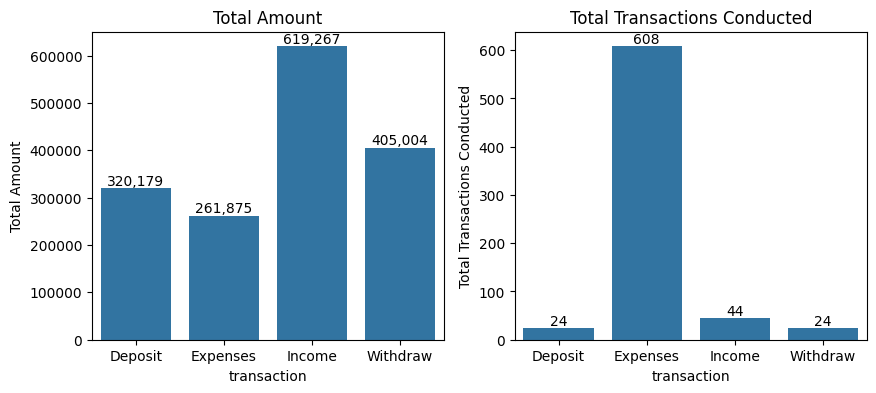

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))                           #<- Setting figure size for bar plot

# Bar Plotting the Data
for idx, col in enumerate(transactions.columns):                        #<- Iterating through columns of transactions DataFrame
    trans = sns.barplot(data=transactions[col], ax=ax[idx])             #<- Bar plot
    for bar in trans.patches:                                           #<- Data labels
        height = bar.get_height()

        if height > 0:
            trans.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', va='bottom', ha='center')
    trans.set_title(col)

# Setting Necessary KPI values 
total_expenses = transactions.loc['Expenses', 'Total Amount']           #<- Total expenses
total_income = transactions.loc['Income', 'Total Amount']               #<- Total income

expen_pcnt = total_expenses / total_income                              #<- Expenses % against total income
net_income_pcnt = abs(total_expenses - total_income) / total_income     #<- Net income % against total income

# Terminal Output
print("Key Performanace Indicator (KPI):")
print(f'Expenses Ratio = {np.round(expen_pcnt * 100, 2):}%')
print(f"Net Income Ratio = {np.round(net_income_pcnt * 100, 2)}%")

transactions

### Descriptive Interpretation
- **Expenses ratio is $42.29$%.**
    - It is **below $60$% which means way below from the warning signs** to be wary about in spending behavior.

- **Net income ratio is $57.71$%.**
    - The percentage of total remaining income after all the spending.
    - **$57.71$% is very high from usual recommendation of $20$%** in personal financing.
        - The remaining money can be either keep to savings or be invested.

- So far, the **highest recorded total amount is the Income category**.
    - Total amount of $\text{Php}\: 619,267$ of gross income.
    - If Expenses category is higher than Income, it could mean I am spending more than earning.
        - Total expenses is $\text{Php}\: 261,875$.

- So far, the **highest recorded transaction is the expenses category**.
    - Total of $608$ recorded transactions.

### **Analyzing Net Income**
Columns involve:
- `'transaction'`
- `'y/m'`
- `'month sort no.'`

In [8]:
# Setting Net Income DF
month_sorting = to_mapping_dict(data=df, dict_key='y/m', dict_val='month sort no.')                 #<- Dictionary for mapping month sorting based on 'y/m' and 'month sort no.' columns
mapdict_year_month_name = to_mapping_dict(data=df, dict_key='y/m', dict_val='year_month name')      #<- Dictionary for mapping name of year and month  

filtering_income_expen = df[(df['transaction'] == 'Income') | (df['transaction'] == 'Expenses')]    #<- Filtering DataFrame for 'Income' and 'Expenses' transactions
piv_net_income = filtering_income_expen.pivot_table(index='y/m',                                    #<- Pivoting the DataFrame to have 'y/m' as index
                               columns='transaction', 
                               values='amount', 
                               aggfunc='sum').reset_index().dropna(subset=['Expenses'])

dates = convert_to_datetime(piv_net_income['y/m'])                                                  #<- Str date converting to datetime object

piv_net_income['Net'] = piv_net_income['Income'] - piv_net_income['Expenses']                       #<- Calculating Net Income
piv_net_income['date'] = piv_net_income['y/m'].map(dates)                                           #<- Mapping dates to pivot table DataFrame
piv_net_income['year_month name'] = piv_net_income['y/m'].map(mapdict_year_month_name)              #<- Mapping name of year and month to pivot table DataFrame
piv_net_income['month_sort'] = piv_net_income['y/m'].map(month_sorting)                             #<- Mapping month sort to pivot table DataFrame

piv_net_income = piv_net_income.set_index('month_sort').sort_index()                                #<- Setting index to 'month_sort' and sorting the DataFrame

piv_net_income

transaction,y/m,Expenses,Income,Net,date,year_month name
month_sort,,,,,,
2,23/11,10181.0,70026.0,59845.0,2023-11-01,2023 November
3,23/12,32023.0,43465.0,11442.0,2023-12-01,2023 December
4,24/1,9647.0,25466.0,15819.0,2024-01-01,2024 January
5,24/2,17583.0,25195.0,7612.0,2024-02-01,2024 February
6,24/3,18789.0,25195.0,6406.0,2024-03-01,2024 March
7,24/4,16059.0,32231.0,16172.0,2024-04-01,2024 April
8,24/5,12242.0,52230.0,39988.0,2024-05-01,2024 May
9,24/6,20411.0,25231.0,4820.0,2024-06-01,2024 June
10,24/7,21985.0,30278.0,8293.0,2024-07-01,2024 July


Mean = 20,938.13
Standard Deviation = 17,726.65
Median = 15,819.0
Skewness = 0.88
Kurtosis = -0.36
Mean-Median Gap = 0.24

There are 6 out of 15 below Php 10,000.
Percent difference of 10,000 to mean = 52%


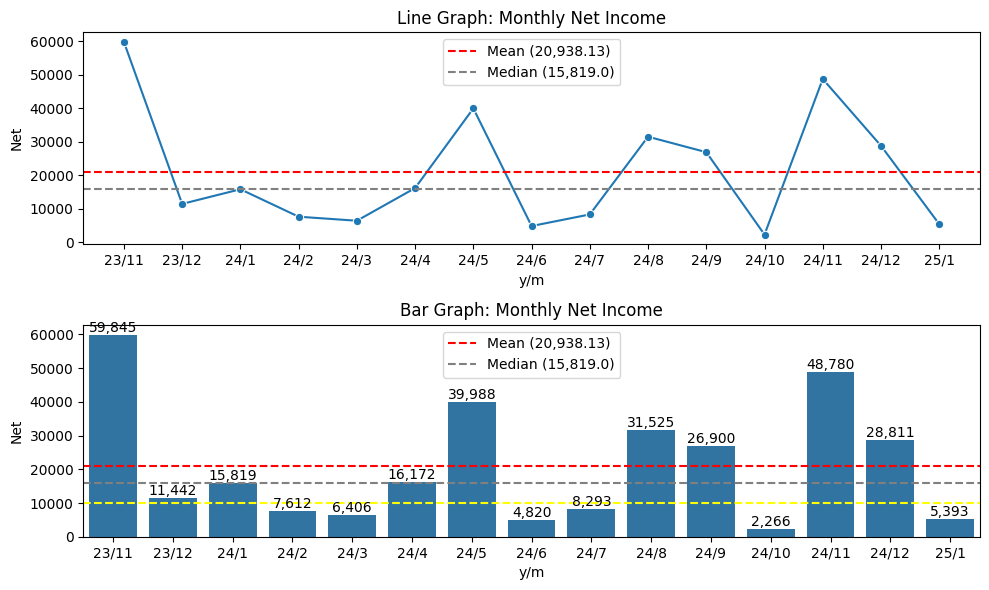

In [9]:
# Plotting Monthly Net Income 
plot_line_bar(dataset=piv_net_income, x='y/m', y='Net', plot_title='Monthly Net Income')    #<- Plotting Net Income by Month

net_income_stat_summary = StatsSummary(piv_net_income['Net'])                               #<- Statistics summary of Monthly Net Income
plt.axhline(10_000, color='yellow', linestyle='--', label='Benchmark')

# Terminal Output
net_income_stat_summary.print_stats(median=True, round_digit=2)

print(f"\nThere are {np.sum(net_income_stat_summary.data < 10_000)} out of {len(net_income_stat_summary.data)} below Php 10,000.")
print(f"Percent difference of 10,000 to mean = {int((1 - 10_000/net_income_stat_summary.mean) * 100)}%")

### Descriptive Interpretation:
- **All months have positive net income**.
    - Net income is the **amount of money left after subtracting all expenses from total income** over a specific period.
    - Could mean I saved these remaining monthly balance.

- Seems like there less months that have net income values around $\text{Php}\: 10,000$ mark net income (yellow line).
    - There are 6 months that are $52$% less from the average monthly net income.
        - **These are months when the expenses are likely high enough** that the remaining monthly income balance is less than $\text{Php}\: 10,000$.
    - It is also worth to view the distributions of this data.

### **Distribution of Monthly Net Income**

Median = 15,819.0
MAD = 10,999.0
Skewness = 0.88
Kurtosis = -0.36
Mean-Median Gap = 0.24


count       15.00
mean     20938.13
std      17726.65
min       2266.00
25%       7009.00
50%      15819.00
75%      30168.00
max      59845.00
Name: Net, dtype: float64

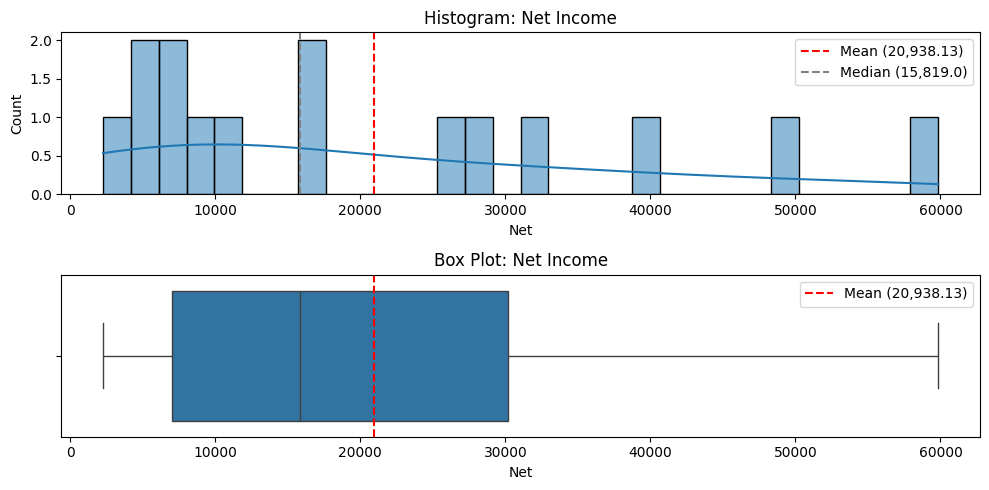

In [10]:
# Plotting Distribution of Net Income
plot_distribution(data=piv_net_income['Net'], plot_title='Net Income')    #<- Plotting distribution of Net Income

# Statistics Summary
net_income_stat_summary.print_stats(mean=False, std=False,                #<- Printing statistics summary for Net Income
                          median=True, mad=True, round_digit=2)
net_income_stat_summary.stat_summary.round(2)

### Descriptive Interpretation:
- ⚠️**Sample size is $15$.**
    - Around sample size of $30$ is considered that the data starting to form roughly normal distribution.
    - **Sample size of $15$ is risky to consider that the data is roughly normal.**

- ⚠️**Skewness is $0.88$**.
    - **Distribution is mildly skewed to the right** (also called positively skewed).
    - It is beyond from 0 to 0.5 values to be considered as roughly normal.
    - Median central tendency would be better.
        - Mean is sensitive towards skews and outliers, resulting to misleading interpretation.
    - Parametric tests and confidence interval are not reliable in this kind of distribution.
        - Using non-parametric tests and bootstrap CI would be much reliable.

- ✅**Kurtosis is $-0.36$**.
    - The tailedness of the data.
        - $>0$ kurtosis.
            - Data can be present on the extremes.
            - Can distort mean and widens standard deviation.
            - Makes mean less reliable as central tendency of the data.
        - $<0$ kurtosis.
            - Data are more concentrated at the center value.
            - Less data on the extremes.
            - Sampling bias could be present if too far from 0.
    - $-0.36$ is between $0$ and $-1$.
        - **Can be safely say the distribution have light tails**.
            - There are no outliers on the data.

- 🚩**Mean-median gap is $24$%**.
    - The value is beyond $20$% to be considered as close together.
        - Mean is being pulled by non-typical data.
        - This **makes our mean to be less reliable as central tendency**.
            - Using **median as central tendency would be better and more reliable**.
            - Using non-parametric tests and bootstrap CI are safer route if inferences needed.

- **Median value is $\text{Php}\: 15,819$.**
    - The middle value of the data.
    - **Typically have monthly net income around $\text{Php}\: 15,819$**.

- **MAD (Median Absolute Deviation) value is $\text{Php}\: 10,999$.**
    - About how much the the net income varies in each month from the median.
    - This means **monthly net income may typically vary around $\text{Php}\: 10,999$ above or below $\text{Php}\: 15,819$.**
        - Typical monthly net income may vary from $\text{Php}\: 4,820$ to $\text{Php}\: 26,818$.

- **IQR is from $\text{Php}\: 7,009.5$ to $\text{Php}\: 30,168$.**
    - The range where 50% values (the half proportion) of the data lies.
    - In other words, the **typical monthly net income is between $\text{Php}\: 7,009.5$ and $\text{Php}\: 30,168$.**

- **In Summary:**
    - The data distribution is **mildly skewed to the right**
    - **Typically have monthly net income around $\text{Php}\: 15,819$**.
        - This may **vary by $\text{Php}\: 10,999$ on average.**
    - **The typical $50$% of monthly net income is between $\text{Php}\: 7,009.5$ and $\text{Php}\: 30,168$.**

### **Smoothing Net Income to Reveal the Trend**
Using 5-month smoothing, it averages the month-to-month net income.

Monthly Net Income:
- Median of Net Income = 15,819.0
- Target 20% (Monthly Net Income) = 6,446.20

Net Income Trend from Mar. 2024 to Jul. 2024:
- Median = 8,293.0
- Target 20% (whole duration) = 33,033.00

- Net Income ratio (whole duration) = 46% (75,679.00)
- Distance from 20% (median)= 1,846.80 (29%)

Net Income Trend from Aug. 2024 and Onwards:
- Mean = 23,945.83
- Target 20% (whole duration) = 49,326.00

- Rolling Difference Average = 1,215.70
- Net Income Ratio (whole duration) = 58% (143,675.00)
- Distance from 20% (mean) = 17,499.63 (271%)

Growth Rate from Last Two Months (Dec. 2024 - Jan. 2025):
- Mean = 17,102

- Dec. 2024 Net = 28,811.00
- Jan. 2025 Net = 5,393.00

- Growth rate = -23,418.0 (-81%)
- Net Income Ratio (whole duration) = 44% (34,204.00)
- Distance from 20% (mean) = 10,655.80 (165%)


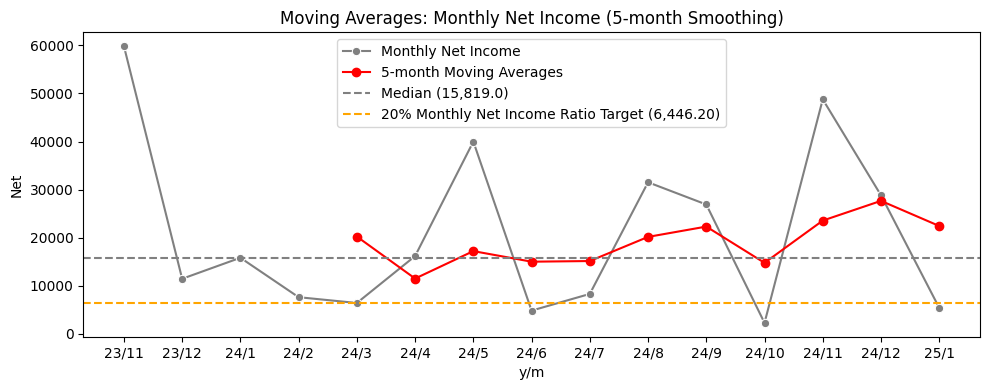

In [ ]:
# Smoothing the Trend by 5 months
mov_ave_monthly_net_income =  moving_ave_smoothing(x_data=piv_net_income['y/m'], 
                                                   y_data=piv_net_income['Net'],
                                                   plot_title='Moving Averages: Monthly Net Income (5-month Smoothing)',
                                                   plot_label='Monthly Net Income',
                                                   smoot_label='5-month Moving Averages')           

target_monthly_net_income = piv_net_income['Income'].median() * .2
plt.axhline(target_monthly_net_income, 
            color='orange', linestyle='--', 
            label=f'20% Monthly Net Income Ratio Target ({piv_net_income['Income'].median() * .2:,.2f})')
plt.legend()

piv_net_income['smooth ave'] = mov_ave_monthly_net_income[1]
piv_net_income['smoothing diff'] = piv_net_income['smooth ave'].diff()

# Filtering Data from Jan. 2024 to Jul. 2024
filter_mar24_jul24 = piv_net_income[
    (piv_net_income['date'] >= '2024-03-01') & (piv_net_income['date'] <= '2024-07-01')             #<- Filtering date from Jan. 2024 to July 2024
]    

median_net = piv_net_income['Net'].median()                                                         #<- Net median

filt_income_sum = filter_mar24_jul24['Income'].sum()                                                #<- Sum of filtered Income 
filt_net_sum = filter_mar24_jul24['Net'].sum()                                                      #<- Sum of filtered Net 
filt_net_median = filter_mar24_jul24['Net'].median()                                                #<- Mean of filtered Net 

# Terminal Output
print('Monthly Net Income:')
print(f"- Median of Net Income = {np.round(median_net,):,}")
print(f"- Target 20% (Monthly Net Income) = {target_monthly_net_income:,.2f}")

print("\nNet Income Trend from Mar. 2024 to Jul. 2024:")
print(f"- Median = {filt_net_median:,}")
print(f"- Target 20% (whole duration) = {filt_income_sum * .2:,.2f}")

print(f"\n- Net Income ratio (whole duration) = {filt_net_sum / filt_income_sum * 100:,.0f}% ({filt_net_sum:,.2f})")
print(f"- Distance from 20% (median)= {filt_net_median - target_monthly_net_income:,.2f} ({(filt_net_median - target_monthly_net_income)/target_monthly_net_income * 100:,.0f}%)")

# Filtering Data from Aug. 2024 and Onwards
filter_gt_jul24 = piv_net_income[piv_net_income['date'] > '2024-07-01']                              #<- Filtering date from Aug. 2024 and onwards

filt_income_sum = filter_gt_jul24['Income'].sum()                                                    #<- Sum of filtered Income
filt_net_sum = filter_gt_jul24['Net'].sum()                                                          #<- Sum of filtered Net
filt_net_mean = filter_gt_jul24['Net'].mean()                                                        #<- Mean of filtered Net

# Terminal Output
print('\nNet Income Trend from Aug. 2024 and Onwards:')
print(f"- Mean = {filt_net_mean:,.2f}")
print(f"- Target 20% (whole duration) = {filt_income_sum * .2:,.2f}")

print(f"\n- Rolling Difference Average = {filter_gt_jul24['smoothing diff'].mean():,.2f}")
print(f"- Net Income Ratio (whole duration) = {filt_net_sum/filt_income_sum * 100:,.0f}% ({filt_net_sum:,.2f})")
print(f"- Distance from 20% (mean) = {filt_net_mean - target_monthly_net_income:,.2f} ({(filt_net_mean - target_monthly_net_income)/target_monthly_net_income * 100:.0f}%)")

# Analyzing the Last Two Months Growth Rate
filter_last_2months = filter_gt_jul24[-2:]                                                          #<- Filtering date

filt_income_sum = filter_last_2months['Income'].sum()
filt_net_sum = filter_last_2months['Net'].sum()
filt_net_mean = filter_last_2months['Net'].mean()                                                   #<- Mean of filtered Net

dec24_net = filter_last_2months['Net'].iloc[0]                                                      #<- Dec. 2024 Net income
jan25_net = filter_last_2months['Net'].iloc[-1]                                                     #<- Jan. 2025 Net income

# Terminal Output
print('\nGrowth Rate from Last Two Months (Dec. 2024 - Jan. 2025):')
print(f"- Mean = {filt_net_mean:,.0f}")

print(f"\n- Dec. 2024 Net = {dec24_net:,.2f}")
print(f"- Jan. 2025 Net = {jan25_net:,.2f}")

print(f"\n- Growth rate = {filter_last_2months['Net'].diff().iloc[-1]:,} ({(jan25_net - dec24_net)/dec24_net * 100:,.0f}%)")
print(f"- Net Income Ratio (whole duration) = {filt_net_sum/filt_income_sum * 100:.0f}% ({filt_net_sum:,.2f})")
print(f"- Distance from 20% (mean) = {filt_net_mean - target_monthly_net_income:,.2f} ({(filt_net_mean - target_monthly_net_income)/target_monthly_net_income * 100:.0f}%)")

### Descriptive Interpretation:
- **NOTE**:
    - No data (no red line) from $\text{Nov.}\: 2023\: \text{(23/11)}$ to $\text{Feb.}\: 2024\: \text{(24/2)}$.
        - Average smoothing needs a certain threshold (this graph have 5 months), before it starts recording.
        - The blank months is when the average are still being computed, so no data points to display until the threshold is met. 

    - Using the ***median of the Net Income as the standard amount for comparison***.
        - **The median is from the raw net income data, not from the smoothed data.**
        - Mean is sensitive to larger values, as on the graph in $(23/11)$, which could mislead to rely on it for analysis in this case.

    - **The net income target is $20$%**.
        - Net income is the saved amount after spending.
        - If the total monthly income is $\text{Php}\: 619,267$, then the target net income is $\text{Php}\: 123,853$.
            - Measures the overall net income.
        - If monthly income is $\text{Php}\: 30,278$, then the target monthly net income is $\text{Php}\: 6,057$.
            - Can be used to measure the per month net income by using mean or the median of a series of months.

- Trend from $\text{Mar.}\: 2024\: \text{(24/3)}$ to $\text{Jul.}\: 2024\: \text{(24/7)}$.
    - **The trend shows no significant growth rate or drop rate.**
        - **The 5-month rolling data points are canceling out the trend**, causing it to have little to no changes of monthly net income.
        - Connecting the raw data points from $\text{Nov.}\: 2023\: \text{(24/3)}$ to $\text{Jul.}\: 2024\: \text{(24/7)}$, the trend might be slightly decreasing.

    - **Net income ratio of these months is $\text{Php}\: 75,679$ or $46$%.**
        - The remaining money gained after all expenditures.
        - $46$% ratio is too far from target $20$%. **The amount to save/invest is beyond from the target.**
        - The middle value of net income of these months is $\text{Php}\: 8,293$, which is $29$% more than the target $20$%.
            - This could mean that **the target monthly savings is more than met** in these filtered months.

- Trend from $\text{Aug.}\: 2024\: \text{(24/8)}$ and Onwards.
    - Based on the 5-month moving averages, these months' trend is increasing by $\text{Php}\: 1,216$ on average.

    - Net income ratio is $58$% $(\text{Php}\: 143,675)$.
        - Way above from the target $20$%, there are more saving than spending.
        - The **average monthly income of these months' is $\text{Php}\: 23,946$.**
            - **Almost 3 times larger than the target $20$%**

- **For the last two months, growth rate is dropping by $81$%.**
    - There were $\text{Php}\: 23,418$ drop of net income from the month of $\text{Dec.}\: 2024\: \text{(24/12)}$ to $\text{Jan.}\: 2025\: \text{(25/1)}$.
    - The net income in $\text{Dec.}\: 2024$ is $\text{Php}\: 28,811$.
        - **It's the month when incentives (13th month pay, christmas bonus, etc.) are given** which causes spikes of income, and possibly as well as the net income.
        - Paired this with seasonal expenses of new years, there were net income of $\text{Php}\: 5,393$ in $\text{Jan.}\: 2025$.
    - **The huge gap from $\text{Php}\: 28,811$ to $\text{Php}\: 5,393$ net income is because of seasonal effects, created a huge drop rate.**

    - **Net income ratio is $44$% $(\text{Php}\: 34,204)$.**
        - **It's still remarkably higher than the $20$% target.**
        - There is $\text{Php}\: 10,656$ difference betweeen the target amount, which is almost 2 times higher than the target.

- **In Summary:**
    - **The general trend of monthly net income is increasing since August 2024.**
    - **The net income ratio is almost two times higher than the target $20$%.**
    - From the last two months, **growth rate is dropping by $81$%** .
        - This drop is **caused by the christmas and new years seasonal expenditure, and by the large income of incentives.**
    - Despite the huge drop rate, **the net income for the last two months is still higher than its target amount by $24$%.**
        - *It is two times higher than the target $20$%.*
    - ***Consider to be cautious*** since the latest month, **$\text{Jan.}\: 2025$, is $\text{Php}\: 1,053$ lower than the target amount.**

## **`Expenses` transactions**
### Monthly Expenses

In [12]:
# Extracting `Expenses` and Make DF
df_expenses = df.loc[df['transaction'] == 'Expenses']

# Group by str `y/m` and Sum their Amount
grpby_expen_by_month = df_expenses.groupby('y/m')['amount'].sum().reset_index()             #<- Grouping by 'y/m' and summing the 'amount' for Expenses

grpby_expen_by_month['date sort no.'] = grpby_expen_by_month['y/m'].map(date_arrangement)   #<- Appending Date Sorting No. for sorting
grpby_expen_by_month = grpby_expen_by_month.sort_values(by='date sort no.')                 #<- Sorting by Date Sorting No.

grpby_expen_by_month

,y/m,amount,date sort no.
0,23/11,10181,2
1,23/12,32023,3
2,24/1,9647,4
6,24/2,17583,5
7,24/3,18789,6
8,24/4,16059,7
9,24/5,12242,8
10,24/6,20411,9
11,24/7,21985,10
12,24/8,11107,11


count       15.00
mean     17458.33
std       6540.11
min       9647.00
25%      11466.00
50%      17583.00
75%      21497.50
max      32023.00
Name: amount, dtype: float64

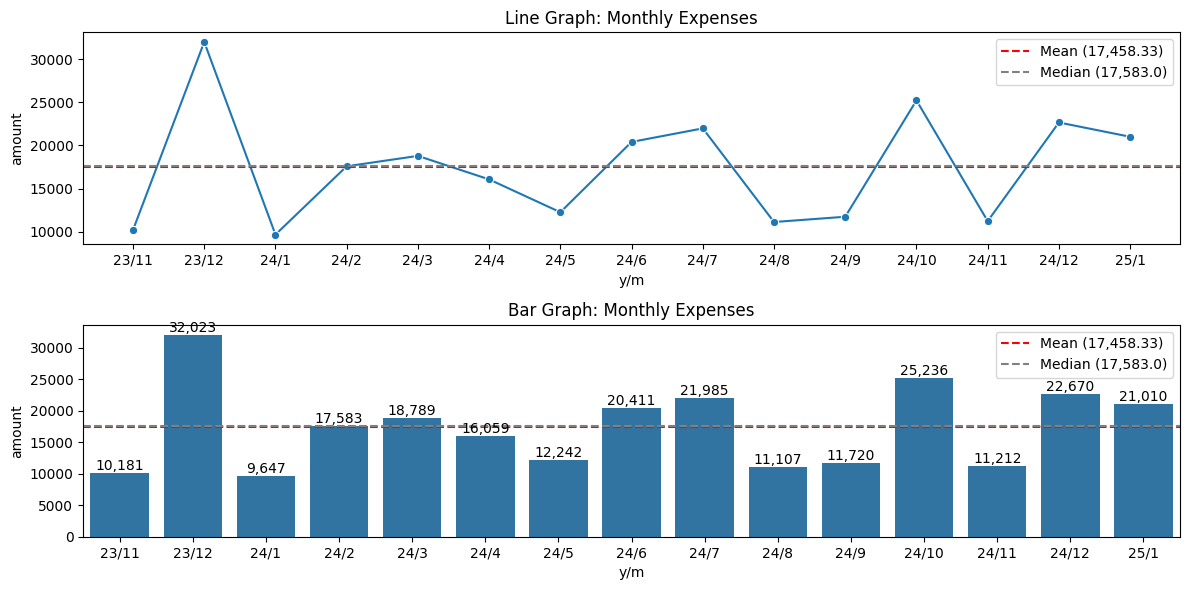

In [13]:
# Setting Mean, Median, and Standard Deviation of Monthly Expenses
stats_monthly_expen = StatsSummary(grpby_expen_by_month['amount'])

# Plotting Monthly Expenses
plot_line_bar(dataset=grpby_expen_by_month, x='y/m', y='amount', plot_title='Monthly Expenses', fig_size=(12, 6))  #<- Plotting Monthly Expenses

# Terminal Output
stats_monthly_expen.stat_summary.round(2)

### Descriptive Interpretation
- **Mean of $\text{Php}\: 17,458.33$.**
    - This means that the **average monthly expenses is $\text{Php}\: 17,458.33$.**

- **Standard deviation of $6,540.11$.**
    - The **average despersion of monthly expenses either above or below $\text{Php}\: 17,458.33$.**

#### **Further Observations:**  
**Line Graph**
1. There are **less variation of monthly expenses from $\text{Feb.}\: 2024\: \text{(24/2)}$ to $\text{Jul.}\: 2024\: \text{(24/7)}$ from the mean**.
    - Are **data points that are not far from the mean line** (the red line).
    - This seems to be the more typical monthly expenses.

2. There are **larger variation of monthly expenses from $\text{Nov.}\: 2023\: \text{(23/11)}$ to $\text{Jan.}\: 2024\: \text{(24/1)}$, and $\text{Sept.}\: 2024\: \text{(24/8)}$ to $\text{Dec.}\: 2024\: \text{(24/12)}$**.
    - These are **data points that are further from the mean line**.
    - The further from the line, the greater variation, and the greater its contribution to increase standard deviation.
    - ***If data point is way greater than the red line,***: 
        - *The expenses maybe greater than usual in that month.*
    - ***If data point is way less than the red line,*** either:
        - *The expenses maybe lesser than usual in that month.*

**Bar Graph**
- The **highest monthly expenses among these months is $\text{Dec.}\: 2023\: \text{(23/12)}$**.
    - The **month's expenses is around $\text{Php}\: 32,000$**.
        - Almost as much as the double amount of the average monthly expenses.
    - Although, $\text{Dec.}\: 2024\: \text{(24/12)}$ total expenses is just approximately $\text{Php}\: 22,700$.
        - $\text{Dec. 2024}$ is $29$% less than $\text{Dec. 2023}$ in terms of monthly expenses.
    - **Inspecting this specific months from the data table could help us understand the expenditure behaviour.**

Go to [Monthly Expenses Confidence Interval (CI)](###estimating-the-true-monthly-expenses-average-by-using-bootstrap-confidence-interval-(CI))

#### Inspecting Why $\text{Dec.}\: 2023$ is the Highest in Terms of Monthly Expenses.

,Total Amount,Count of Transactions
details,,
balay (nov),5000,1
battery,3600,1
hatag kanda mama,3000,1
SSD,2900,1
laptop keyboard,2600,1
Gasolina (nov),2100,1
Ebo Sweldo,1500,1
laptop upgrade labor,1500,1
medisina,1375,1


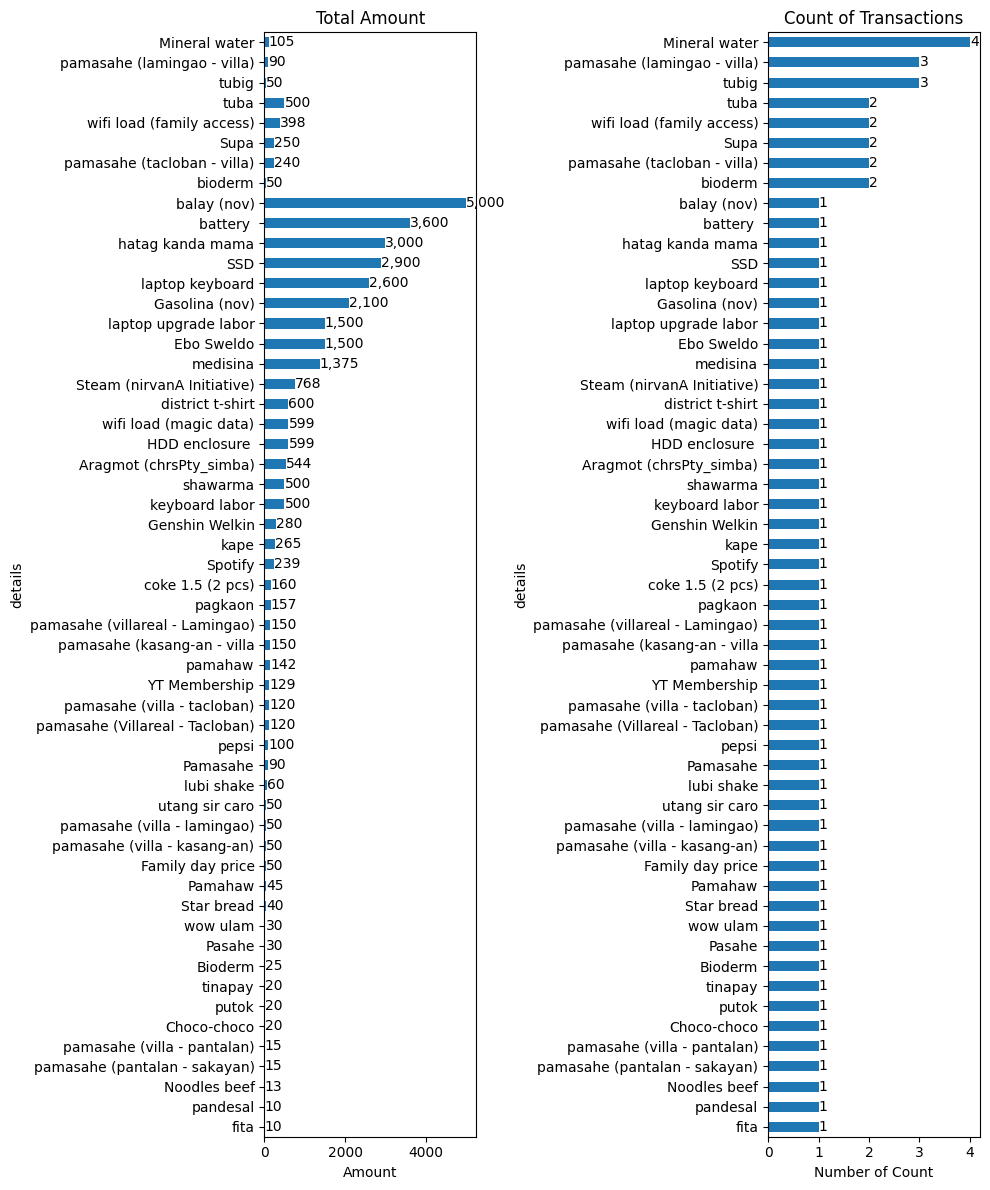

In [14]:
# Setting DataFrame for December 2023 Expenses Details
dec_2023_expen = df_expenses[df_expenses['y/m'] == '23/12']                                     #<- Filtering DataFrame for December 2023 expenses
grpby_dec2023 = dec_2023_expen.groupby('details')['amount'].agg(['sum', 'count']).sort_values(by=['count', 'sum'], ascending=True)  #<- Grouping December 2023 expenses by 'details' and summing the 'amount', also counting the number of transactions, then sorting by count and sum
grpby_dec2023.columns = ['Total Amount', 'Count of Transactions']                               #<- Renaming columns for clarity
x_axis = ['Amount', 'Number of Count']                                                          #<- X-axis labels for bar plot      

# Plotting Total Amount and Counts of Transactions for December 2023 Expenses
fig, ax = plt.subplots(1, 2, figsize=(10, 12))                                                  #<- Setting figure size for bar plot

for idx, col in enumerate(grpby_dec2023.columns):                                               #<- Iterating through columns of grouped DataFrame
    plt0 = grpby_dec2023.reset_index().plot(kind='barh', x='details', y=col, ax=ax[idx])        #<- Plotting bar graph for December 2023 expenses

    for bar in plt0.patches:                                                                    #<- Data labels
        height = bar.get_width()
        if height > 0:
            plt0.text(height, bar.get_y() + bar.get_height()/2, f'{height:,.0f}', va='center', ha='left')

    plt0.set_title(f"{col}")
    plt0.set_xlabel(x_axis[idx])                                                                #<- Setting x-axis label
    plt0.legend().set_visible(False)                                                            #<- Hiding legend for each subplot

plt.tight_layout()

# Terminal Output (Filtered and Sorted December 2023 Expenses Details)
grpby_dec2023[grpby_dec2023['Total Amount'] >= 1000].sort_values(by='Total Amount', ascending=False)  #<- Filtering and sorting December 2023 expenses details with total amount greater than 1000

### Descriptive Interpretation:
- On the filtered data table, it shows transaction in the month of $\text{Dec.}\: 2023$ that have greater than or equal to $\text{Php}\: 1000$ total amount.
    - The unsual expenses are:
        - battery $(\text{Php}\: 3,600)$
        - hatag kanda mama $(\text{Php}\: 3,000)$
        - SSD $(\text{Php}\: 2,900)$
        - laptop keyboard $(\text{Php}\: 2,600)$
        - laptop upgrade labor $(\text{Php}\: 1,500)$
        - medisina $(\text{Php}\: 1,375)$
    - The **unusuals expenses are mostly from laptop repair and parts**.

#### We can safely say:
- **The expenses are higher in $\text{Dec.}\: 2023$ because of laptop repair and upgrade expenses**.

### **Monthly Expenses Distribution**

Mean = 17,458.33
Standard Deviation = 6,540.11
Skewness = 0.57
Kurtosis = -0.42
Mean-Median Gap = 0.01


count       15.00
mean     17458.33
std       6540.11
min       9647.00
25%      11466.00
50%      17583.00
75%      21497.50
max      32023.00
Name: amount, dtype: float64

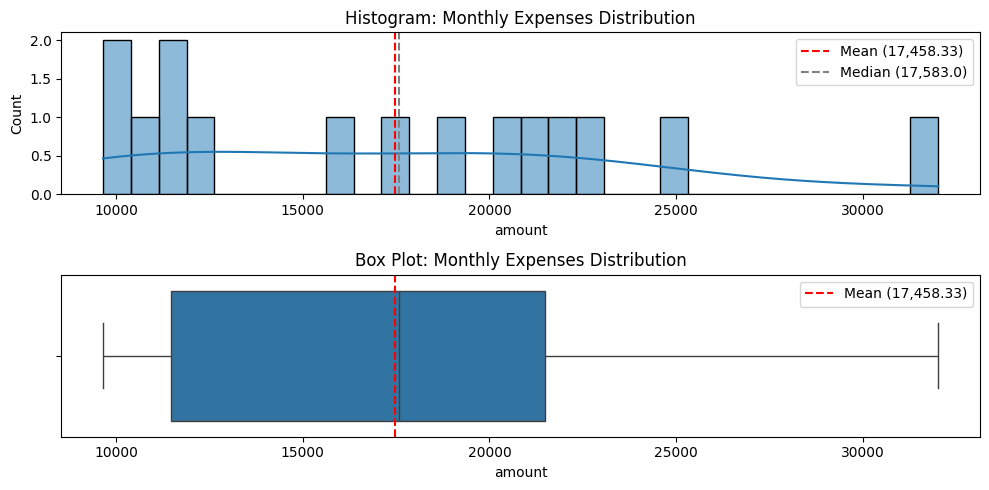

In [15]:
# Distribution Check with Distribution Plot
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution')

# Terminal Output
stats_monthly_expen.print_stats(round_digit=2)          #<- Printing statistics summary for Monthly Expenses with rounding to 2 decimal places
stats_monthly_expen.stat_summary.round(2)

### Descriptive Interpretation
- ⚠️**Sample size is $15$.**
    - Sample size is too small to for normally distributed data.
    - **Risky to safely consider a distribution as normally distributed.**

- ⚠️**Skewness is $0.57$.**
    - The distribution is **mildly skewed to the right**.
    - It is **beyond from $0$ to $0.5$** to be considered as roughly normal.

- ✅**Kurtosis is $-0.42$.**
    - It is between $0$ and $-1$ and much nearer to $0$.
        - The **tail of the distribution is roughly normal**.
            - The mean is not pulled much away by the data on the extremes.
            - The **mean and standard deviation of the data is still reliable dispite being mildly skewed**.

- ✅**Mean-median gap is $1$%.**
    - The gap is $<10%$, median is not distant to the mean.
        - This **further reinforces that mean is still reliable** as the distribution's central tendency.
    - Using parametric tests and CI in this data could still be reliable if inferences and modeling are needed.

- **Mean is $\text{Php}\: 17,458$**.
    - **Monthly expenses is around $\text{Php}\: 17,458$ on average.**

- **Standard Deviation is $\text{Php}\: 6,540$.**
    - The average variation of uncertainty from the mean.
    - **Monthly expenses may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**

- **IQR of $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$.**
    - **It is not unusual to have monthly expenses between $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$ in a typical month.**

- **In Summary:**
    - Mean and standard deviation are still reliable despite the distribution's mild skewness.
        - Still reliable for descriptive statistics.
        - Using parametric tests and CI in this data could be shaky and not ideal, but can still be utilized if inferences are needed.
    - **Average monthly expenses is around $\text{Php}\: 17,458$.**
    - **It may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**
    - **It is not unusual to have monthly expenses between $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$ in a typical month.**

### **Monthly Expenses Regression Plot**
Building model to analyze the trends.

Text(0.5, 0, 'Months passes over time')

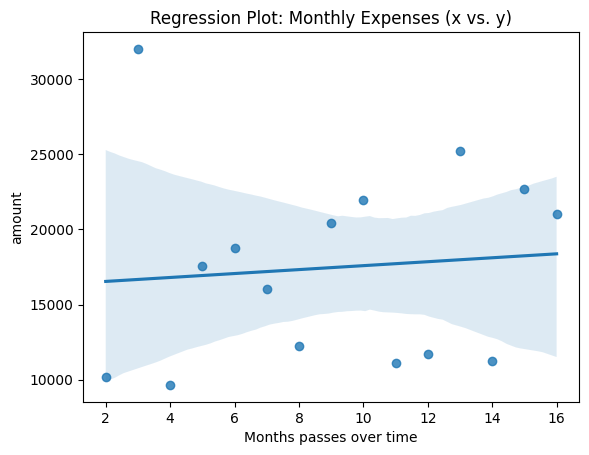

In [16]:
# Regression Plot
sns.regplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='amount')
plt.title('Regression Plot: Monthly Expenses (x vs. y)')
plt.xlabel('Months passes over time')

### Linear Regression Test
Checking regression line's accuracy 
- Raw Linear regression (x vs. y model)

In [17]:
# Checking Regression Line's Accuracy
reg_expen = scistat.linregress(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['amount'])  #<- Regression
slope_expen = reg_expen.slope                               #<- slope (rate of change as x changes)
intercept_expen = reg_expen.intercept                       #<- y-intercept

# Terminal Output
print(f"y = {slope_expen:.3f}x + {intercept_expen:.3f}")
print(f"R = {reg_expen.rvalue: .3f}")
print(f"R^2 = {reg_expen.rvalue ** 2: .4f}")

y = 131.264x + 16276.955
R =  0.090
R^2 =  0.0081


In [18]:
# Appending Predictions and Residuals for Better Data Visualization
y_pred = (grpby_expen_by_month['date sort no.'] * slope_expen) + intercept_expen    #<- y prediction calculation 
resid = grpby_expen_by_month['amount'] - y_pred                                     #<- Residuals calculation

grpby_expen_by_month['y pred'] = y_pred                                             #<- Appending y prediction
grpby_expen_by_month['resid'] = resid                                               #<- Appending residuals
grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid
0,23/11,10181,2,16539.483333,-6358.483333
1,23/12,32023,3,16670.747619,15352.252381
2,24/1,9647,4,16802.011905,-7155.011905
6,24/2,17583,5,16933.276190,649.723810
7,24/3,18789,6,17064.540476,1724.459524
8,24/4,16059,7,17195.804762,-1136.804762
9,24/5,12242,8,17327.069048,-5085.069048
10,24/6,20411,9,17458.333333,2952.666667
11,24/7,21985,10,17589.597619,4395.402381
12,24/8,11107,11,17720.861905,-6613.861905


Text(0, 0.5, 'Residuals')

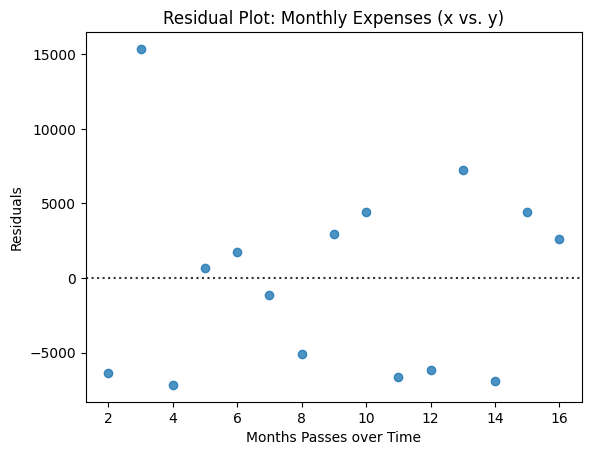

In [19]:
# Residual Plotting to Check How Scattered the Estimate Around the Model
sns.residplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='resid')
plt.title('Residual Plot: Monthly Expenses (x vs. y)')
plt.xlabel('Months Passes over Time')
plt.ylabel('Residuals')

In [20]:
# Calculating RMSE, MAE and NRME
r2_raw = metrics.r2_score(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred'])
rmse = np.sqrt(np.sum(grpby_expen_by_month['resid']**2)/len(grpby_expen_by_month['resid']))
mae = np.sum(np.abs(grpby_expen_by_month['resid'])) / len(grpby_expen_by_month['resid'])
nrmse = rmse / stats_monthly_expen.mean

# Terminal Output
print('Summary of Descriptive Stats and Metric Calculation:')                                       #<- Descriptive Statistics
print(f" - Mean Monthly Expenses = {stats_monthly_expen.mean:.3f}")
print(f" - Standard Deviation of Monthly Expenses (std)= Php {stats_monthly_expen.std:.3f}")

print('\nRegression Metrics:')                                                                      #<- Regression Metrics
print(f" - R^2 = {r2_raw: .3f}")
print(f" - Root Mean Square Error (RMSE) = {rmse:.3f}")
print(f" - Mean Absolute Error (MAE) = {mae:.3f}")
print(f" - mean-Normalized Root Mean Squarer Error (NRMSE) = {nrmse * 100:.2f}%\n")

print("Checking if RMSE < std:")                                                                    #<- Check RMSE vs std
print(f' - RMSE < std = {rmse:.3f} < {stats_monthly_expen.std:.3f} =  {rmse < stats_monthly_expen.std}')
print(f" - Percent difference = {(1 - (rmse/stats_monthly_expen.std)) * 100:.2f}%")                 #<- Percent difference between RMSE and std

Summary of Descriptive Stats and Metric Calculation:
 - Mean Monthly Expenses = 17458.333
 - Standard Deviation of Monthly Expenses (std)= Php 6540.107

Regression Metrics:
 - R^2 =  0.008
 - Root Mean Square Error (RMSE) = 6292.840
 - Mean Absolute Error (MAE) = 5251.202
 - mean-Normalized Root Mean Squarer Error (NRMSE) = 36.04%

Checking if RMSE < std:
 - RMSE < std = 6292.840 < 6540.107 =  True
 - Percent difference = 3.78%


### Model Metric Interpretation (x vs. y model):
- ✅**RMSE is $3.78$% less than standard deviation.**
    - Translating how much uncertainty or error the model have compared to mean as an estimator.
    - The model have $3.4$% less error, therefore it is better than using the mean to predict a value.
    - $3.78$% is too small difference, it means **the model is barely better than using mean as an estimator**.

- ⚠️ **$R^2$ is $0.8$%.**
    - The model explains nothing about the variance in expenses.
    - The **model isn't capturing any meaningful pattern.**

- ⚠️**NRMSE is approx. $36.04$%.**
    - Usually, $<10$% is considered excellent
        - $10–20$% is good, and 
        - $>30$% is considered poor prediction in many domains.
    - The average prediction error is about $36.69$% of the target mean value.
    - This could mean that if the mean expenses is approximately $\text{Php}\; 17,000$, then the **prediction is approximately $\text{Php}\; 6,100$ off on average**, when accounting for large mistakes.

- ✅**Residual Plot: Scattered Around the Model.**
    - The model doesn't have clear structural bias.
    - The model doesn't misfitting the trend. 

### Overall Assessment:
- **The model is barely better than using mean as an estimator**.
    - It is slightly reduced error compared to them mean as an estimator.
- Usable, but expect nothing when it comes to the precision. 
- Further feature exploration or alternative models are recommended.

## Data Transformation Attempt: x vs. log(y)
An attempt for exploring alternative predicting models and reducing the raw linear regression model's RMSE.

,y/m,amount,date sort no.,y pred,resid,log
0,23/11,10181,2,16539.483333,-6358.483333,9.228279
1,23/12,32023,3,16670.747619,15352.252381,10.374210
2,24/1,9647,4,16802.011905,-7155.011905,9.174402
6,24/2,17583,5,16933.276190,649.723810,9.774688
7,24/3,18789,6,17064.540476,1724.459524,9.841027
8,24/4,16059,7,17195.804762,-1136.804762,9.684025
9,24/5,12242,8,17327.069048,-5085.069048,9.412628
10,24/6,20411,9,17458.333333,2952.666667,9.923829
11,24/7,21985,10,17589.597619,4395.402381,9.998116
12,24/8,11107,11,17720.861905,-6613.861905,9.315331


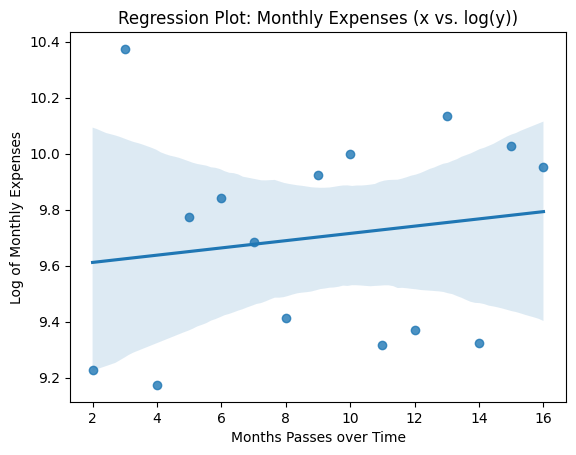

In [21]:
# Transforming Y with log() base 10
grpby_expen_by_month['log'] = np.log(grpby_expen_by_month['amount'])

# Scatter Plot Visulization with Approximate Linear Regression
sns.regplot(x=grpby_expen_by_month['date sort no.'], y=np.log(grpby_expen_by_month['amount']))
plt.title('Regression Plot: Monthly Expenses (x vs. log(y))')
plt.xlabel('Months Passes over Time')
plt.ylabel('Log of Monthly Expenses')

grpby_expen_by_month

In [22]:
# Modeling log(y)
model_monthly_expen = LinearRegression()
model_monthly_expen.fit(X=grpby_expen_by_month['date sort no.'].values.reshape(-1, 1), y=grpby_expen_by_month['log'])

log_y_coef = model_monthly_expen.coef_[0]                           #<- Coefficient (slope)
log_y_intrcpt = model_monthly_expen.intercept_                      #<- Intercept

print(f"y = e^({log_y_coef:.3f}x + {log_y_intrcpt:.3f})")           #<- Terminal Output (Transformed Model)

y = e^(0.013x + 9.586)


In [23]:
# Appending y Prediction from log and Its Residuals to the DataFrame
grpby_expen_by_month['y pred (log)'] = np.exp(log_y_coef * grpby_expen_by_month['date sort no.'] + log_y_intrcpt)   #<- Calc y predictions
grpby_expen_by_month['resid (log)'] = grpby_expen_by_month['amount'] - grpby_expen_by_month['y pred (log)']         #<- Appending

grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid,log,y pred (log),resid (log)
0,23/11,10181,2,16539.483333,-6358.483333,9.228279,14940.412156,-4759.412156
1,23/12,32023,3,16670.747619,15352.252381,10.374210,15135.260864,16887.739136
2,24/1,9647,4,16802.011905,-7155.011905,9.174402,15332.650735,-5685.650735
6,24/2,17583,5,16933.276190,649.723810,9.774688,15532.614909,2050.385091
7,24/3,18789,6,17064.540476,1724.459524,9.841027,15735.186961,3053.813039
8,24/4,16059,7,17195.804762,-1136.804762,9.684025,15940.400901,118.599099
9,24/5,12242,8,17327.069048,-5085.069048,9.412628,16148.291185,-3906.291185
10,24/6,20411,9,17458.333333,2952.666667,9.923829,16358.892716,4052.107284
11,24/7,21985,10,17589.597619,4395.402381,9.998116,16572.240853,5412.759147
12,24/8,11107,11,17720.861905,-6613.861905,9.315331,16788.371418,-5681.371418


Text(0, 0.5, 'Residuals (log)')

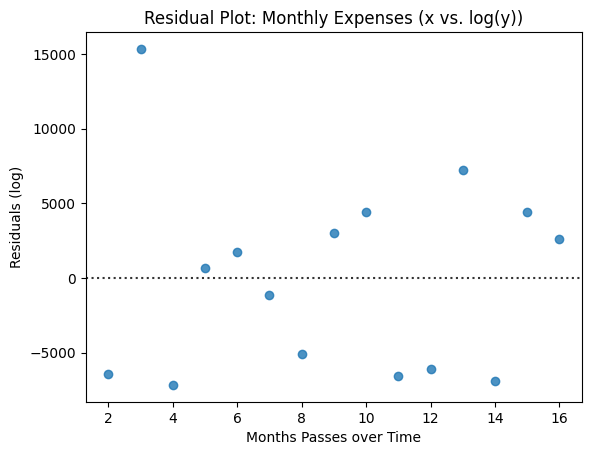

In [24]:
# Residual Plot of y Prediction
sns.residplot(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['resid (log)'])
plt.title('Residual Plot: Monthly Expenses (x vs. log(y))')
plt.xlabel('Months Passes over Time')
plt.ylabel('Residuals (log)')

In [25]:
# Regression Metrics Calculation
rval_log_y, _ = scistat.pearsonr(grpby_expen_by_month['date sort no.'].values, grpby_expen_by_month['log'])
r2_log_y = metrics.r2_score(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
rmse_log_y = metrics.root_mean_squared_error(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
nrmse_log_y = rmse_log_y/grpby_expen_by_month['amount'].mean()

# Terminal Output
print('Monthly Expenses Stats (Php):')                                                              #<- Stats Summary
stats_monthly_expen.print_stats(round_digit=3, skew=False, kurtosis=False, mean_median_gap=False)   #<- Printing stats summary without skewness, kurtosis, and mean-median gap

print('\nRegression Metrics:')                                                                      #<- Regression Metrics
print(f" - R = {rval_log_y:.4f}")
print(f" - R^2 = {r2_log_y * 100:.2f}%")
print(f" - RMSE = {rmse_log_y:,.2f}")
print(f" - NRMSE = {nrmse_log_y * 100:.2f}")

print('\nChecking RMSE vs. std')                                                                    #<- Checking RMSE vs Std
print(f' - RMSE < std = {rmse_log_y:.3f} < {stats_monthly_expen.std:.3f} =  {rmse_log_y < stats_monthly_expen.std}')
print(f" - Percent difference = {(1 - (rmse_log_y/stats_monthly_expen.std)) * 100:.2f}%")           #<- Percent difference between RMSE and std

Monthly Expenses Stats (Php):
Mean = 17,458.333
Standard Deviation = 6,540.107

Regression Metrics:
 - R = 0.1548
 - R^2 = -2.28%
 - RMSE = 6,390.00
 - NRMSE = 36.60

Checking RMSE vs. std
 - RMSE < std = 6390.003 < 6540.107 =  True
 - Percent difference = 2.30%


### Model Metric Interpretation (x vs. log(y) model):
- 🚩 **$R^2$ is $-2.28$%.**
    - **Negative $R^2$ is worse than a flat mean guess.**
    - The model doesn't catch meaningful patterns of the data.

- ⚠️ **NRMSE is approximately $36.6$%.**
    - Larger than what we would want, which is $<30$%.
    - This could mean that if the average expenses is $\text{Php}\; 15,000$, then the **prediction is approximately $\text{Php}\; 5,500$ off on average**, when accounting for large mistakes.

- ⚠️ **RMSE is $2.3$% less than standard deviation.**
    - The model have $2.3$% less average error than the mean have.
        - **The model is better than using mean as an estimator in terms of average prediction error**.
            - Though the mean catches more meaningful pattern of the data than the model does.
        - Though, $2.3$% difference away from mean is too small.
        - The model barely have less error than the mean.

- ✅Residual Plot: Scattered arount the model.
    - The model likely have no clear structural bias.
    - The model doesn't misfitting the trend.

### Overall Assessment:
- It is better to use mean an estimator than this model.
- Though the model predicts less error, but it doesn't capture meaningful pattern of the data.
- The model seems to not show any bias.
- Raw linear regression is better than this model.
- **Failed attempt to reduce the raw linear regression model's RMSE.**

### **Model Selection for Monthly Expenses**
- Choosing the best model to interpret monthly expenses data.

In [26]:
# Storing Model Version to DataFrame
models_vers = {'Model Version': ['linereg_v1_raw', 'linereg_v2_log_y'],         #<- Storing model version to DataFrame
               'Note': ['x vs. log(y)', 'x vs. log(y)'],
               'slope': [slope_expen, log_y_coef], 
               'intercept': [intercept_expen, log_y_intrcpt],
               'R':[reg_expen.rvalue, rval_log_y], 
               'R^2': [reg_expen.rvalue ** 2, r2_log_y],
               'RMSE': [rmse, rmse_log_y],
               'NRMSE': [nrmse, nrmse_log_y]}  

model_ver_data = pd.DataFrame(models_vers)                                      #<- DataFrame for the models

# Terminal Output
model_ver_data                                                              

,Model Version,Note,slope,intercept,R,R^2,RMSE,NRMSE
0,linereg_v1_raw,x vs. log(y),131.264286,16276.954762,0.089759,0.008057,6292.839633,0.360449
1,linereg_v2_log_y,x vs. log(y),0.012957,9.585910,0.154833,-0.022812,6390.002577,0.366014


### Model Selection Summary:
- ⚠️$R^2$ is at least $0.3$. 
    - $0.3$ is the desirable value for this regresssion metrics.
    - **No model passed from this desirable value.**
    - **Every model built is risky to rely for prediction.**

- ⚠️RMSE have $0.3$ value at most.
    - All models exceeded from the desirable value, therefore, not reliable to rely for prediction.

- ⚠️**No model have selected as it all have poor reliability.**
    - Since linear models fail, **using moving averages smoothing would be the practical next move** to detect the trend of the data.
        - This might give up inferences, but can gain descriptive clarity.

- Review the metrics summary here:
    - Go to [Model Metric Interpretation (x vs. y model)](###model-metric-interpretation-(x-vs.-y-model):)
    - Go to [Model Metric Interpretation (x vs. log(y) model)](###model-metric-interpretation-(x-vs.-log(y)-model):)

### **Moving Averages Smoothing** 

Median = 17,583.0
5-month Smoothing Average = 72.50

Last Two Months Expenses:
- Previous Month = 22,670
- Latest Month = 21,010
- Mean = 21,840.0

- Growth rate = -7% (-1,660)
- Distance of mean from the median = 4,257 (24%)

Christmas-New Years Season Expenses Analysis:
- Sum of Dec. 2023 & Jan. 2024 Expenses = 41,670.00
- Sum of Dec. 2024 & Jan. 2025 Expenses = 43,680.00

- 2023-2024 vs. 2024-2025 Christmas-New Years Expenses Difference = 2,010.00
- 2023-2024 vs. 2024-2025 Christmas-New Years Expenses Percent Difference = 5%


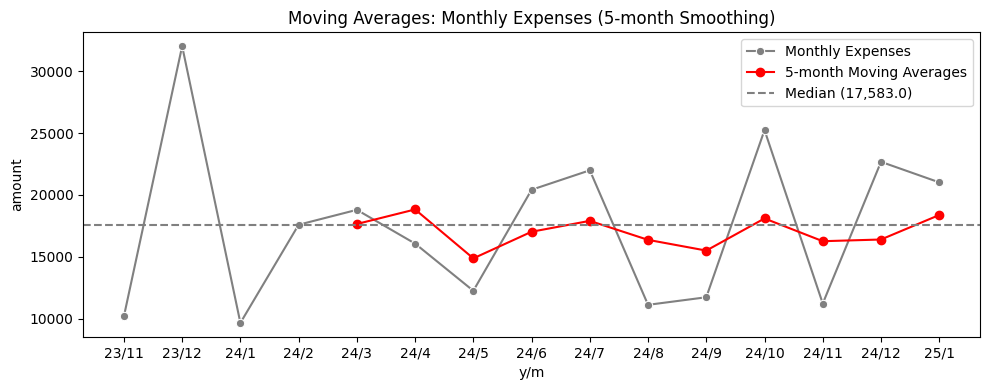

In [27]:
# Moving Averages Smoothing of Monthly Expenses
moving_ave_monthly_expen = moving_ave_smoothing(x_data=grpby_expen_by_month['y/m'],                                 #<- Moving averages of monthly expenses
                                                y_data=grpby_expen_by_month['amount'],
                                                plot_title='Moving Averages: Monthly Expenses (5-month Smoothing)',
                                                plot_label='Monthly Expenses',
                                                smoot_label='5-month Moving Averages')

# Setting the Monthly Expenses Trend Analysis
copydf = grpby_expen_by_month.copy()
expen_by_month = copydf.loc[:, ['y/m', 'amount', 'date sort no.']]

expen_by_month['mov ave'] = moving_ave_monthly_expen[1]
expen_by_month['mov ave diff'] = expen_by_month['mov ave'].diff()

expen_by_month_median = expen_by_month['amount'].median()

print(f"Median = {expen_by_month_median:,}")
print(f"5-month Smoothing Average = {expen_by_month['mov ave diff'].dropna().mean():,.2f}")

# Last Two Months
prev_month = expen_by_month['amount'].iloc[-2]
latest_month = expen_by_month['amount'].iloc[-1]
sum_last_two_months = expen_by_month['amount'][-2:].sum()
mean_last_two_months = expen_by_month['amount'][-2:].mean()

print('\nLast Two Months Expenses:')
print(f"- Previous Month = {np.round(prev_month,):,}")
print(f"- Latest Month = {np.round(latest_month,):,}")
print(f"- Mean = {mean_last_two_months:,}")

print(f"\n- Growth rate = {(latest_month - prev_month)/prev_month * 100:,.0f}% ({latest_month - prev_month:,})")
print(f"- Distance of mean from the median = {mean_last_two_months - expen_by_month_median:,.0f} ({(mean_last_two_months - expen_by_month_median)/expen_by_month_median * 100:,.0f}%)")

# Comparing the Christmas-New Years Expenses from 2023-2024 and 2024-2025
dec23_jan24_expenses = expen_by_month[(expen_by_month['y/m'] == '23/12') | (expen_by_month['y/m'] == '24/1')]['amount'].sum()       #<- Filtering data from Dec. 2023 to Jan. 2024

print('\nChristmas-New Years Season Expenses Analysis:')
print(f'- Sum of Dec. 2023 & Jan. 2024 Expenses = {dec23_jan24_expenses:,.2f}')
print(f'- Sum of Dec. 2024 & Jan. 2025 Expenses = {sum_last_two_months:,.2f}')

print(f"\n- 2023-2024 vs. 2024-2025 Christmas-New Years Expenses Difference = {sum_last_two_months - dec23_jan24_expenses:,.2f}")
print(f"- 2023-2024 vs. 2024-2025 Christmas-New Years Expenses Percent Difference = {(sum_last_two_months - dec23_jan24_expenses) / dec23_jan24_expenses * 100:,.0f}%")

### Descriptive Interpretation:
- **The trend is barely increasing by $\text{Php}\: 72.5$ based on the 5-month moving average.**

- **For the last 2 months, monthly expenses is dropping by $7$% (Dec. 2024 to Jan. 2025).**
    - The monthly expenses of $\text{Jan.}\: 2025\: \text{(25/1)}$ is $\text{Php}\: 1,660$ higher than the previous month $(\text{Dec.}\: 2024)$.
    - Even though the rate is dropping, the average monthly expenses is still above from the median. 
        - **The average of these monthly expenses is $\text{Php}\: 4,257$ higher than the median.**
        - It is still high because of Christmas and New Years season-related purchases.

- Comparing the previous Christmas and New Year monthly expenses with the current months.
    - $\text{2023-2024}$ Christmas-New Years monthly expenses is $\text{Php}\: 2,010$ than the current months.
    - Compared to the past Christmas season, the **current $\text{2023-2024}$ Christmas-New Years monthly expenses is $5$% higher.**

- **In Summary:**
    - In general, **monthly expenses trend is slightly increasing** on average.
    - **For the last two months, monthly expenses dropped by $7$%** from $\text{Dec.}\: 2024$ to $\text{Jan.}\: 2025$.
        - Despite the drop, the ***average expenses of these months is $24$% above from the median.***
    - Spike of monthly expenses is caused by Christmas and New Years season-related purchases.
    - The Christmas and New Years season-related expenses of $\text{2024-2025}$ (the recent season) is higher than the same season in year $\text{2023-2024}$ (the previous season).

## **Confidence Interval (CI)**
#### What is the true monthly expenses?

Mean = 17,458.33
Standard Deviation = 6,540.11
Skewness = 0.57
Kurtosis = -0.42
Mean-Median Gap = 0.01


count       15.00
mean     17458.33
std       6540.11
min       9647.00
25%      11466.00
50%      17583.00
75%      21497.50
max      32023.00
Name: amount, dtype: float64

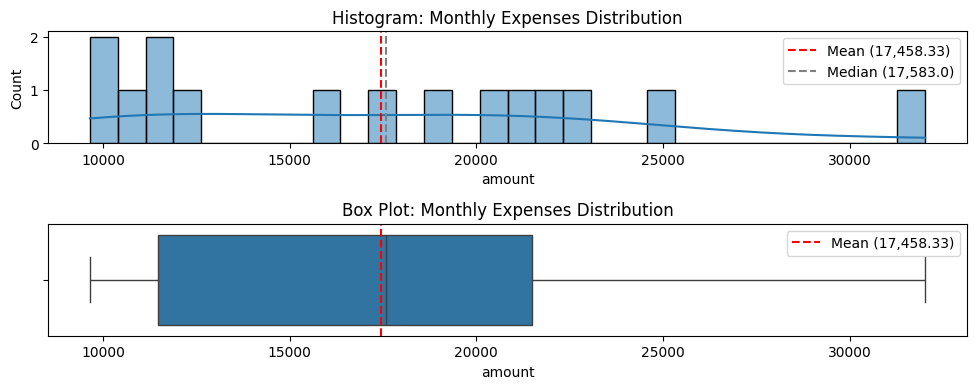

In [28]:
# Distribution Check with Distribution Plot
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution', fig_size=(10, 4))

# Terminal Output
stats_monthly_expen.print_stats(round_digit=2)
stats_monthly_expen.stat_summary.round(2)

### Distribution Interpretation Summary:
- Mean and standard deviation are still reliable dispite the distribution's mild skewness.
    - Using mean and standard deviation are still reliable for descriptive statistics.
    - Using parametric tests and CI in this data could be shaky and not ideal, but can still be utilized if inferences are needed.
- **Monthly expenses is around $\text{Php}\: 17,458$ on average.**
- **Monthly expenses may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**
- **It is not unusual to have monthly expenses between $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$ in a typical month.**

### **Estimating the True Monthly Expenses Average by Using Bootstrap Confidence Interval (CI)**
- The distribution can be assumed as normal in descriptive analysis, analysts should **analyze with caution when drawing inference**.
- Non-parametric CI, like **bootstrap, would be the safest route to avoid misleading inferences**.

In [29]:
# Confidence Interval of Monthly Expenses Average
monthly_expen_ci = ConfidenceInterval(grpby_expen_by_month['amount'])
ci, btsrp_means, approx_moe = monthly_expen_ci.bootstrap_ci(more_details=True).values()

# Terminal Output
print(f"95% Bootstrap CI:")
print(f" - Lower bound = {ci[0]:,.2f}")
print(f" - Upper bound = {ci[1]:,.2f}")

95% Bootstrap CI:
 - Lower bound = 14,359.59
 - Upper bound = 20,719.17


### Inferential Interpretation:
- There's **$95$% confidence that the confidence interval procedure captures the true average monthly expenses**.
    - $95$% does not mean the chance of capturing.
    - It means if we sample from the population many times, then get the CI each of those trials, $95$% out of those trials will capture the true population mean.
- The **confidence interval is between around $\text{Php}\: 14,400$ and around $\text{Php}\: 20,700$**, where the true average lies.

### **Bootstrapping Visualization:**

BOOTSTRAP SAMPLING STATISTIC SUMMARY:
Mean = 17,429.86
Standard Deviation = 1,613.591
Skewness = 0.131
Kurtosis = -0.052
Mean-Median Gap = 0.001

Bootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php 14,359.590
 - Upper Bound = Php 20,719.175



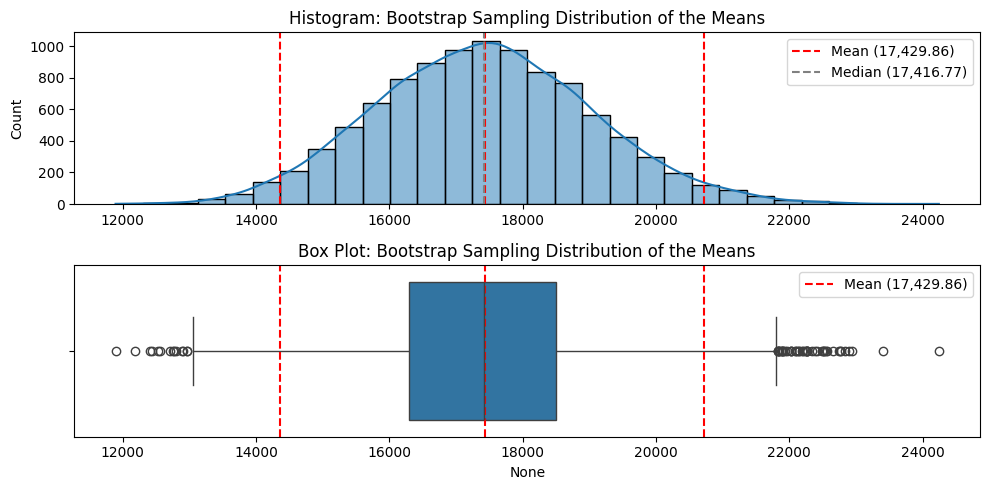

In [30]:
# Setting Statistic Summary of the Bootstrap Sampling
btsrp_means_stats =  StatsSummary(pd.Series(btsrp_means))

# Histogram Plotting
plot_distribution(btsrp_means_stats.data, plot_title='Bootstrap Sampling Distribution of the Means', ci=(ci[0], ci[1]))

# Terminal Output
print('BOOTSTRAP SAMPLING STATISTIC SUMMARY:')
btsrp_means_stats.print_stats(round_digit=3)

print(f"""\nBootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php {ci[0]:,.3f}
 - Upper Bound = Php {ci[1]:,.3f}\n""")

### Descriptive Interpretation:
- ✅**Skewness is around $0.13$.**
    - Values is between $0$ and $-1$.
    - It is **roughly normally distributed**.

- ✅**Kurtosis is around $-0.052$.**
    - Value is between $-1$ and $0$.
        - This means the tailedness is light 
        - Data are more concentrated at the center and fewer on the tails.
    - The value is closer to $0$ than $-1$.
        - Supports more on normal tail than light-tailed.
    - The tailedness is **roughly normal**.

- ✅**Mean-median Gap is around $0.001$.**
    - The value is basically almost $0$.
    - There is a very slight distance between mean and median.
        - **The distribution is likely symmetric.**

- **Overall Assessment:**
    - The distribution is roughly normal.
    - **It is safe to say that the bootstrap CI is reliable.**

### Giving Context on the Bootstrap Confidence Interval

In [31]:
# Comparing CI to Mean and Standard Deviation for Context
print(f"Mean = Php {stats_monthly_expen.mean:,.3f}")                                                        #<- Mean
print(f"Standard Deviation = Php {stats_monthly_expen.std:,.3f}")                                           #<- Std
print(f"""\nBootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php {ci[0]:,.2f}
 - Upper Bound = Php {ci[1]:,.2f}\n""")                                                                  #<- CI

# Margin of Error
print('Margin of Error:')
print(f" - MOE = {approx_moe:,.3f}")                                                                        #<- MOE
print(f" - % of MOE against the Mean = {approx_moe / stats_monthly_expen.mean * 100:,.2f}%")                #<- MOE / mean
print(f" - % of MOE against the Standard Deviation = {approx_moe / stats_monthly_expen.std * 100: ,.2f}%")  #<- MOE / Std

Mean = Php 17,458.333
Standard Deviation = Php 6,540.107

Bootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php 14,359.59
 - Upper Bound = Php 20,719.17

Margin of Error:
 - MOE = 3,179.792
 - % of MOE against the Mean = 18.21%
 - % of MOE against the Standard Deviation =  48.62%


### Interpretation:
- 📝**Margin of Error is around $\text{Php}\: 3,170$:**
    - MOE says that we have that amount of **uncertainty either the true monthly expenses is $3,170$ below or above** from our average estimate.

- 👍**Relative MOE** $(\frac{\text{MOE}}{\text{mean}})$:
    - Tells us the precision of the CI by comparing its MOE against the mean.
    - Usually:
        - $< 5$% --> High precision
        - $5$% - $10$% --> Acceptable precision
        - $10$% - $20$% --> Moderate uncertainty
        - $> 20$% --> High uncertainty
    - There's approximately **$18$% MOE against to mean**.
        - **Moderate uncertainty. Usable for personal finance tracking.**

- 👌 **CI width Against Standard Deviation $(\frac{\text{MOE}}{\text{std}})$:**
    - Tells us the overall spread (or noise) of MOE compared to standard deviation.
    - How informative or vague the estimate of CI.
    - Usually:
        - $< 20$% --> Excellent precision, and low variability.
        - $20$% - $50$% --> Moderate precision and variability.
        - $50$% --> CI is wide and has high variability.
    - There's **$48$% MOE against to standard deviation** (std).
        - **The CI has moderate precision but still meaningful.**

#### **Overall Assessment:**
- The CI has moderate uncertainty though still meaningful.
- The CI has moderate precision and variability.
- **There is less risk on using the CI to estimate the true monthly expenses average.**

# **Daily Expenses** 
Total daily expenses.

In [32]:
# Setting Daily Expenses DataFrame
df_daily_expen = df_expenses.groupby('y/m/d')['amount'].sum().reset_index()

# Descriptive Statistics Summary
stats_daily_expen = StatsSummary(df_daily_expen['amount'])

# Terminal Output
df_daily_expen

,y/m/d,amount
0,23/11/10,73
1,23/11/13,162
2,23/11/14,25
3,23/11/15,125
4,23/11/16,55
...,...,...
229,25/1/22,129
230,25/1/24,788
231,25/1/4,9100
232,25/1/6,239


### **Data Distribution Check**

Daily Expenses Stats Summary:
count      234.00
mean      1119.12
std       2254.63
min          5.00
25%        125.00
50%        239.00
75%        691.00
max      10360.00
Name: amount, dtype: float64 

Median = 239.0
MAD = 157.0
Skewness = 2.66
Kurtosis = 5.97
Mean-Median Gap = 0.79


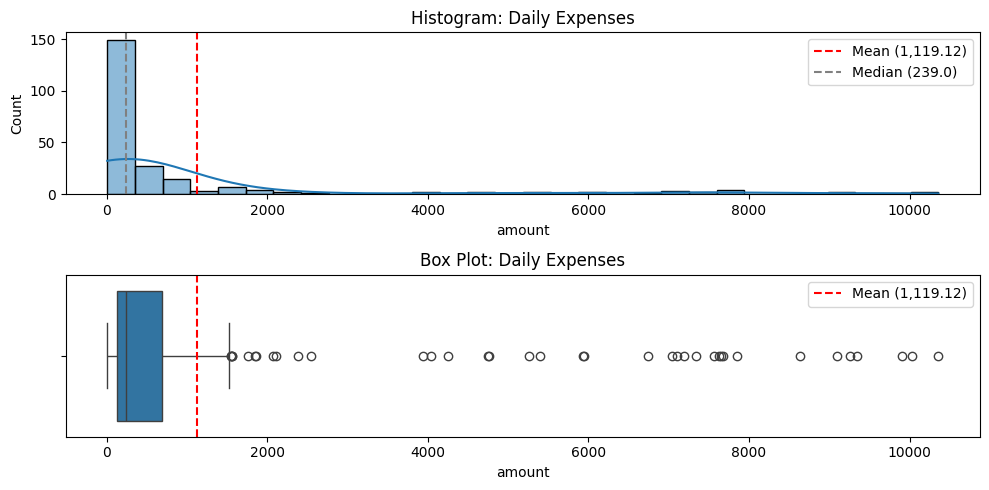

In [33]:
# Distribution Check Using Histogram and Boxplot
plot_distribution(data=stats_daily_expen.data, plot_title='Daily Expenses')

# Terminal Output
print('Daily Expenses Stats Summary:')                  
print(stats_daily_expen.stat_summary.round(2), '\n')

stats_daily_expen.print_stats(mean=False, std=False, median=True, mad=True, round_digit=2)

### Descriptive Interpretation:
- ✅There are $234$ number of samples.
    - Has enough number of samples for reliable descriptive distribution check.

- ⚠️**Skewness is $2.66$.**
    - The value is above $1$.
        - The skewness beyond this value is considered as skewed.
    - **The distribution is skewed to the right.**

- ⚠️**Kurtosis is $5.97$.**
    - The tailedness of the data distribution.
        - $>1$ means *Heavy tail*.
            - Ouliers are more concentrated from one tail.
        - From $0$ to $\pm 0.5$ means *Normal* or *roughly normal tail*.
            - Data and outliers are evenly distributed in both tails
        - $< -1$ means *Light tail*.
            - Data are more concentrated on the center and less outliers.
    - **The distribution is heavily tailed.**
    - The box plot shows the outliers in the distribution.
        - **The more outliers present, the heavier the tailedness of the distribution.**

- ⚠️**Mean-median Gap is $79$%.**
    - The gap distance between the mean and median.
    - **The value shows the mean and median are significantly distant from one another.**
        - Hints that the distribution might be skewed.

- **Median and MAD are more reliable** as central tendency and variability.
    - In the case of skewed distribution, mean and standard deviation are risky and less reliable.
        - Mean and standard deviation are sensitive to outliers.
        - The more outliers, the less reliable mean and standard deviation becomes.
    - Utilizing median (gray line) to determine the middle value of daily expenses is more stable.

- **Median is $\text{Php}\: 239$.**
    - **The middle value of daily expenses is $\text{Php}\: 239$.**

- **MAD (median absolute deviation) is $\text{Php}\: 157$.**
    - **The daily expenses may vary either $157$ below or above the median.**

- **IQR is $\text{Php}\: 125$ and $\text{Php}\: 691$.**
    - **The $50$% typical daily expenses is between $\text{Php}\: 125$ and $\text{Php}\: 691$.**

- **In Summary:**
    - **The data distribution is skewed to the right.**
    - **Middle value of daily expenses is $\text{Php}\: 239$.**
    - **The daily expenses may vary either $\text{Php}\: 157$ below or above the median.**
    - **The typical daily expenses is between $\text{Php}\: 125$ and $\text{Php}\: 691$.**

## **Monthly `Income` Analysis**
Analysis on monthly income.

In [34]:
# Extracting Income Data and Making Separate DF
df_income = df[df['transaction'] == 'Income']

# Group by `y/m` and Sum their Amount
grpby_income = df_income.groupby('y/m')['amount'].sum().reset_index()

map_month = df.loc[:, ['y/m', 'month sort no.']].drop_duplicates().set_index('y/m').to_dict()['month sort no.'] #<- Mapping dict
grpby_income['month sort no.'] = grpby_income['y/m'].map(map_month)                                             #<- Appeding mapping to Df
grpby_income = grpby_income.sort_values(by='month sort no.').set_index('month sort no.')                        #<- Sorting values

# Setting Stats Summary of Monthly Income
stats_monthly_income = StatsSummary(grpby_income['amount'])

# Terminal Output
grpby_income

,y/m,amount
month sort no.,,
0,23/9,17732
1,23/10,25588
2,23/11,70026
3,23/12,43465
4,24/1,25466
5,24/2,25195
6,24/3,25195
7,24/4,32231
8,24/5,52230


Monthly Income Statisitc Summary (in Php):


,index,amount
0,count,17.00
1,mean,36427.47
2,std,14692.16
3,min,17732.00
4,25%,25466.00
5,50%,30278.00
6,75%,43465.00
7,max,70026.00


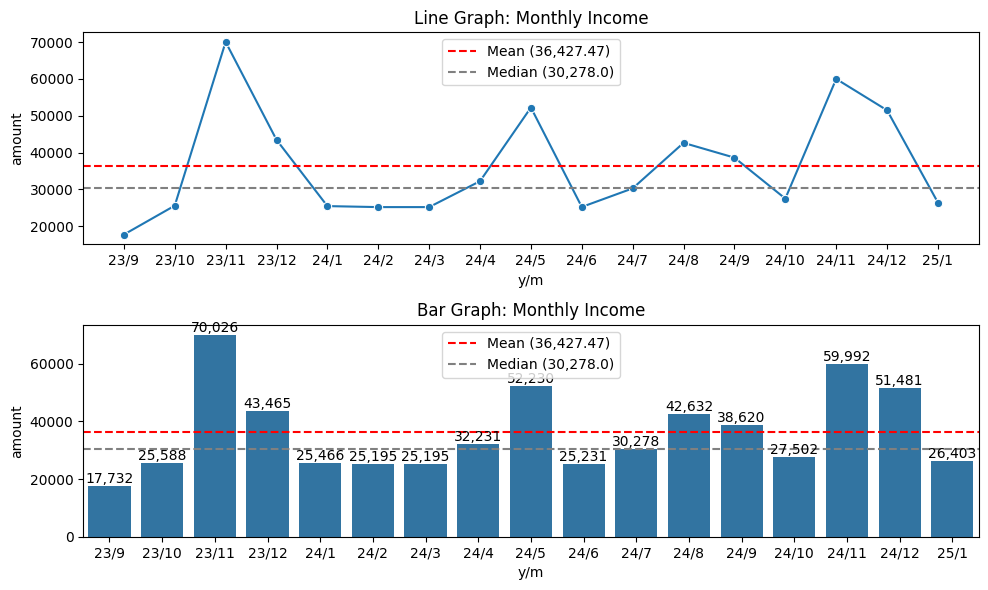

In [35]:
# Plotting Monthly Income in Line and Bar Graph
plot_line_bar(dataset=grpby_income, x='y/m', y='amount', plot_title='Monthly Income')  #<- Plotting Monthly Income

# Terminal Output
print("Monthly Income Statisitc Summary (in Php):")
stats_monthly_income.stat_summary.reset_index().round(2)

### Descriptive Interpretation:
**Line Graph**
- Income are at **highest during November and December** month of each year.
    - Could be **caused by $13th$ month pay and other incentives**.
- Monthly income has average variation of approximately $\text{Php}\;14,700$.
- The data average seems to be pulled by the high income months.
    - This indicate that data could be skewed. 
    - Visualizing with histogram and box plot would confirm it.

**Bar Graph**
- **Nov. of 2023, Nov.** and **Dec. of 2024** had higher income.
    - These are months where **there are some other source of income other than teaching**.
    - Might be the **reason why there's a large variation of monthly income**.

### Inspecting Why November and December have the Highest Monthly Income in These Years.

In [36]:
# Filtering Data that are in November and December in Any Given Year
nov_dec_income_detail = df_income[(df_income['month'] == 11) | (df_income['month'] == 12)]

# Translating Details from Foreign Script to English Alphabetical Script
detail_col_nov_dec_income = nov_dec_income_detail['details'].unique().tolist()                                  #<- Listing the `details` column

foreign_detail = {'サラリー': 'Salary', '歳末のボーナス': 'Year-end Bonus', '第十三月のサラリー': '13th Month Pay'} #<- Mapping translation

tl_detail: dict = {}                                                                                            #<- Empty dictionary
for detail in detail_col_nov_dec_income:                                                                        #<- Iterate list of `details` column 
    if detail in foreign_detail.keys():                                                                         #<- If key is in foreign script
        tl_detail[detail] = foreign_detail[detail]
    else:                                                                                                       #<- If key is in English
        tl_detail[detail] = detail

clean_nov_dec_income_detail = nov_dec_income_detail.copy()                                                      #<- Copying the filtered DF to avoid error
clean_nov_dec_income_detail['tl details'] = nov_dec_income_detail.loc[:,'details'].map(tl_detail)               #<- Appending the translated column into the DF

# Creating Pivot Table of Monthly Income Based on the Details
piv_nov_dec_income_detail = clean_nov_dec_income_detail.pivot_table(index='tl details', values='amount', columns='y/m', aggfunc=['sum', 'count']).round(2)
piv_nov_dec_income_detail

sum                            count              \
y/m                     23/11    23/12    24/11    24/12 23/11 23/12 24/11   
tl details                                                                   
13th Month Pay            NaN      NaN      NaN  25000.0   NaN   NaN   NaN   
Income (with bonus?)  44732.0      NaN      NaN      NaN   1.0   NaN   NaN   
SRI                       NaN  18000.0      NaN      NaN   NaN   1.0   NaN   
Salary                12734.0  25465.0  27992.0  26481.0   1.0   2.0   2.0   
Tahong harvest        12560.0      NaN      NaN      NaN   1.0   NaN   NaN   
Year-end Bonus            NaN      NaN  27000.0      NaN   NaN   NaN   1.0   
cash gift                 NaN      NaN   5000.0      NaN   NaN   NaN   1.0   

                            
y/m                  24/12  
tl details                  
13th Month Pay         1.0  
Income (with bonus?)   NaN  
SRI                    NaN  
Salary                 2.0  
Tahong harvest         NaN  
Year-end Bonus         NaN  
cash gift              NaN

,y/m,amount
0,23/11,70026
2,24/11,59992
3,24/12,51481
1,23/12,43465


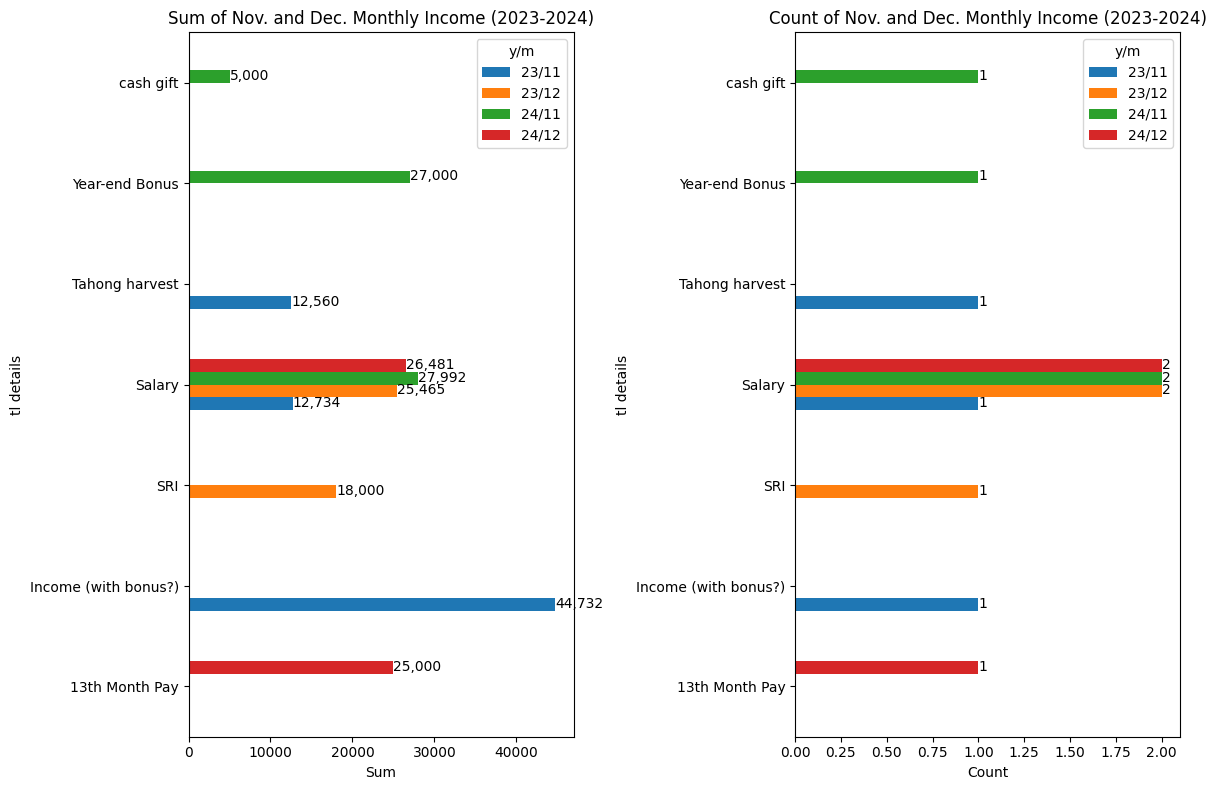

In [37]:
# Setting Subplots for Plotting
fig, ax = plt.subplots(1, 2, figsize=(12,8))

# Plotting Sum and Counts of Monthly Income Transactions
for plot, col in enumerate(['sum', 'count']):                                               #<- Iterating two columns from DF
    plt0 = piv_nov_dec_income_detail.plot(kind='barh', y=col, ax=ax[plot])

    for bar in plt0.patches:                                                                #<- Data label
        width = bar.get_width()
        if width > 0:
            plt0.text(x=width, y=bar.get_y(), s=f'{int(width):,}', va='bottom', ha='left')
    
    plt0.set_title(f'{col.capitalize()} of Nov. and Dec. Monthly Income (2023-2024)')       #<- Title
    plt0.set_xlabel(col.capitalize())                                                       #<- X-label

plt.tight_layout()

# Terminal Output
nov_dec_income_detail.groupby('y/m')['amount'].sum().reset_index().sort_values(by='amount', ascending=False)

### Descriptive Interpretation:
- **The only usual monthly income is the *Salary*.**
    - Everything else are unusuals because they are either incentives or other income source.

- **Highest monthly income among these months is $\text{November}\: 2023\: (2023/11)$.**
    - Since *Income (with bonus?)* contributed the highest among the transactions in this month by $\text{Php}\: 44,732$.
    - *Tahong harvest* is also one of the unusuals in this month's transaction and it is from the other income source.
    - ***Income (with bonus?)* and *Tahong harvest* are unsual transactions that have good amount to contribute total monthly income.**

- Comparing the November months to the December months.
    - **November months have the most unusuals that also have high amount of income.**
        - ***Income (with bonus?)*** with $\text{Php}\: 44,732$ income.
        - ***Year-end Bonus*** with $\text{Php}\: 27,000$ income.
        - ***Tahong harvest*** with $\text{Php}\: 12,560$ income.

- **In Summary:**
     - **November and December months have the highest monthly income because these are the months when incentives and other income sources comes.**

### **Monthly Income Distribution**

Median = 30,278.0
MAD = 5,083.0
Skewness = 0.89
Kurtosis = -0.27
Mean-Median Gap = 0.17


count       17.00
mean     36427.47
std      14692.16
min      17732.00
25%      25466.00
50%      30278.00
75%      43465.00
max      70026.00
Name: amount, dtype: float64

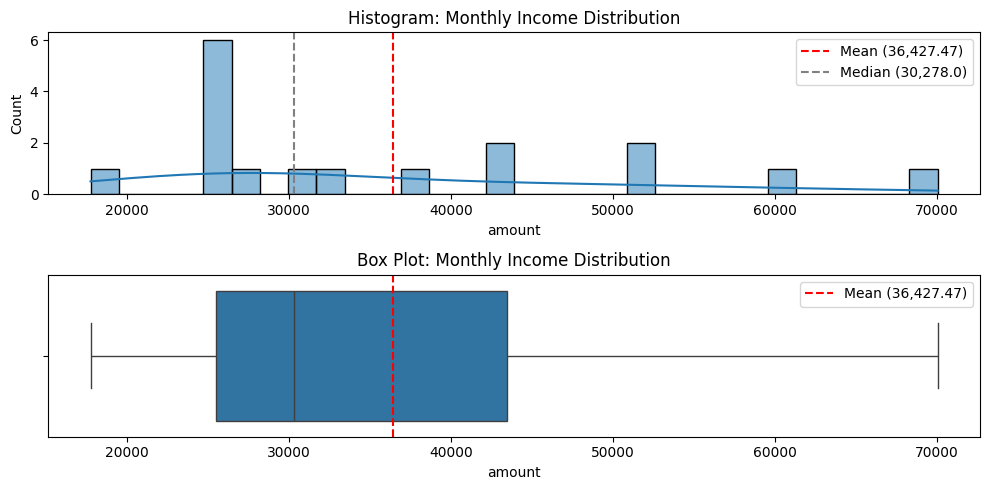

In [38]:
# Distribution Plot for Monlthy Income 
plot_distribution(data=stats_monthly_income.data, plot_title='Monthly Income Distribution')  #<- Plotting Monthly Income Distribution

stats_monthly_income.print_stats(mean=False, std=False, median=True, mad=True, round_digit=2)
stats_monthly_income.stat_summary.round(2)

#### Descriptive Interpretation:
- ⚠️**The sample size is $17$.**
    - Usually, sample size of $30$ could reveal if the distribution is at least roughly normal.
    - **$17$ sample size is not large enough to safely say it is roughly normally distributed.**

- ⚠️**Skewness is $0.89$.**
    - The value is between $0.5$ and $1$.
        - **The distribution is slightly skewed to the right.**

- ✅**Kurtosis is $-0.27$.**
    - The tailedness of the distribution.
    - The value is between $0$ and $-0.5$.
        - **The tails are roughly normal.**
        - The outliers are roughly evenly distributed in both tails (if any).

- ⚠️**Mean-median Gap is $0.17$.**
    - The gap distance between mean and median.
    - The gap value is $> 15$.
        - **The gap value is far and could indicate a strong skew.**

- 📝**Overall Distribution Assessment:** 
    - **The distribution is skewed to the right.**
    - **Median seems more reliable than using mean** in this state.

- **Median is $\text{Php}\: 30,278$.**
    - **The middle value of monthly income is $\text{Php}\: 30,278$.**

- **MAD (Median Absolute Deviation) is $\text{Php}\: 5,083$.**
    - How much monthly income spreads from median on average.
    - **The monthly income varies $\text{Php}\: 5,083$ either above or below the median $(\text{Php}\: 30,278)$.**

- **IQR is $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**
    - **Typical $50$% of monthly income is in between $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**

- **In Summary:**
    - The monthly income distribution is positively skewed.
    - **The middle value of monthly income is $\text{Php}\: 30,278$.**
    - **Monthly income varies from $\text{Php}\: 25,195$ to $\text{Php}\: 35,361$ around the median.**
    - The **typical $50$% proportion of monthly income is in between $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**

### **Monthly Income Trend Analysis**

Text(0.5, 0, 'Month Passes over Time')

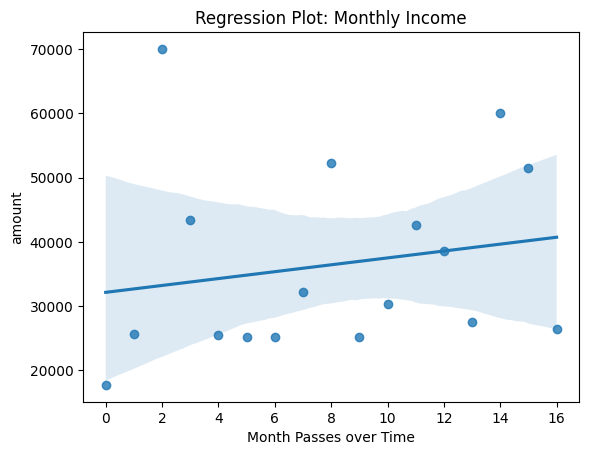

In [39]:
# Regression plot
sns.regplot(data=grpby_income, x=grpby_income.index, y='amount')
plt.title('Regression Plot: Monthly Income')
plt.xlabel('Month Passes over Time')

In [40]:
# Getting Slope and Intercep Value of Regression Line
reg_income = scistat.linregress(x=grpby_income.index, y=grpby_income['amount']) #<- Reg. line
slope_income = reg_income.slope                                                 #<- slope
intercept_income = reg_income.intercept                                         #<- y-intercept

# Terminal Output
print(f"y = {slope_income:.3f}x + {intercept_income:.3f}")
print(f"R = {reg_income.rvalue:.3f}")
print(f"R^2 = {reg_income.rvalue **2 :.3f}")

y = 536.012x + 32139.373
R = 0.184
R^2 = 0.034


In [41]:
# Amount Estimate and Residual Calcualtion
y_pred = (grpby_income.index * slope_income) + intercept_income     #<- Monthly income amount esimate
resid = grpby_income['amount'] - y_pred                             #<- Residuals

# Appending Monthly Amount Income Estimate and Residuals
grpby_income['y pred'] = y_pred                                     #<- Monthly Amount Income
grpby_income['resid'] = resid                                       #<- Residuals
grpby_income

,y/m,amount,y pred,resid
month sort no.,,,,
0,23/9,17732,32139.372549,-14407.372549
1,23/10,25588,32675.384804,-7087.384804
2,23/11,70026,33211.397059,36814.602941
3,23/12,43465,33747.409314,9717.590686
4,24/1,25466,34283.421569,-8817.421569
5,24/2,25195,34819.433824,-9624.433824
6,24/3,25195,35355.446078,-10160.446078
7,24/4,32231,35891.458333,-3660.458333
8,24/5,52230,36427.470588,15802.529412


Number of Data Points = 17
Overestimated = 10
Underestimated = 7


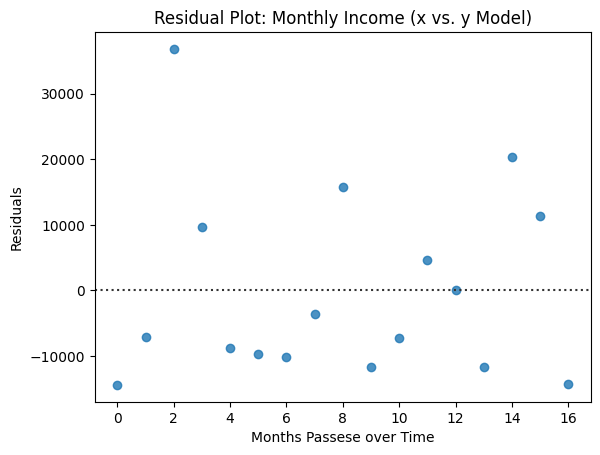

In [42]:
# Residual Plot
sns.residplot(x=grpby_income.index, y=grpby_income['resid'])
plt.title('Residual Plot: Monthly Income (x vs. y Model)')
plt.xlabel('Months Passese over Time')
plt.ylabel('Residuals')

print(f"Number of Data Points = {len(grpby_income['resid'])}")
print(f"Overestimated = {len(grpby_income.loc[grpby_income['resid'] < 0, 'amount'])}")
print(f"Underestimated = {len(grpby_income.loc[grpby_income['resid'] > 0, 'amount'])}")


### Descriptive Interpretation:
- ⚠️Residual plot **shows funnel-like pattern.**
    - The residuals are forming small residuals in early months and it increases as months passes.
        - Shows the that error variance are not constant or equal.
        - **This could mean that the linear model becomes unreliable over time.**
    - Might be due to seasonal income makes the income volatile.

- ⚠️The residual plot **shows asymmetry between the underestimated and overestimated residuals.**
    - Overestimated (below 0 residuals):
        - *There are more number of residuals.*
        - *They are less far from the 0 than the residuals above zero.*
    - Underestimated (above 0 residuals):
        - *There are less number of residuals.*
        - *Are much more further from 0 than the residuals below zero.*
    - **This suggests model bias.**
        - The model does not accounting well for a change in trend.

- **In Summary:**
    - **Residual plot alone shows the the model is no longer reliable.**
        - Skipping to check linear regression metrics since the model is not longer reliable.

### **Smoothing Data Points to Spot Trend of Monthly Income**
Smoothing the data to spot monthly income trend.

Monthly Income:
- Median Income = 30,278
- Rolling diff. Average = 362.02
- Mean Moving average (Start to Apr. 24) = -2,048.33
- Mean Moving average (Apr.24 and onwards) = 293.02

Last Two Months Monthly Income:
- Previous Month = 51,481
- Latest Month = 26,403
- Mean = 38,942

- Growth rate = -49% (-25,078)
- Distance from Median (Latest month) = -3,875 (-13%)
- Distance from Median (Mean) = 8,664 (29%)


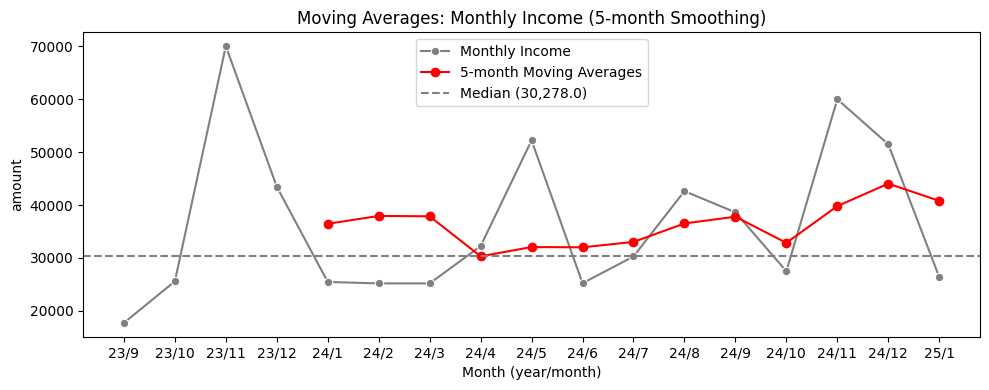

In [69]:
# Plotting Moving Averages to Visualize Trend
monthly_income_mov_ave = moving_ave_smoothing(x_data=grpby_income['y/m'],                  #<- Moving averages plotting
                     y_data=grpby_income['amount'],
                     plot_title='Moving Averages: Monthly Income (5-month Smoothing)',
                     plot_label='Monthly Income',
                     smoot_label='5-month Moving Averages',
                     x_label='Month (year/month)')

# Setting Dataframe of Monthly Income
grpby_monthly_income = grpby_income.copy().loc[:, ['y/m', 'amount']]                                                    #<- Copying DF
monthly_income_median = grpby_monthly_income['amount'].median()                                                         #<- Median of monthly income

grpby_monthly_income['moving ave'] = monthly_income_mov_ave[1]                                                          #<- Appending moving averages return values
grpby_monthly_income['moving ave diff'] = grpby_monthly_income['moving ave'].diff()                                     #<- Appending moving averages month-to-month difference
grpby_monthly_income['date'] = grpby_monthly_income['y/m'].map(convert_to_datetime(grpby_monthly_income['y/m']))        #<- Converting str to datetime type

monthly_income_ls_apr24 = grpby_monthly_income[grpby_monthly_income['date'] >= '2024-04-01']                            #<- Date less or equal than Apr. 2024
monthly_income_gt_apr24 = grpby_monthly_income[grpby_monthly_income['date'] <= '2024-04-01']                            #<- Date greater than equal than Apr. 2024

# Terminal Output
print('Monthly Income:')
print(f"- Median Income = {monthly_income_median:,.0f}")
print(f"- Rolling diff. Average = {grpby_monthly_income['moving ave diff'].mean():,.2f}")
print(f"- Mean Moving average (Start to Apr. 24) = {monthly_income_gt_apr24['moving ave diff'].dropna().mean():,.2f}")
print(f"- Mean Moving average (Apr.24 and onwards) = {monthly_income_ls_apr24['moving ave diff'].mean():,.2f}")

# Last Two Months
last_two_months_income: pd.DataFrame = grpby_monthly_income[-2:]['amount']                                              #<- Last two months income amount
last_two_months_diff: pd.Series = last_two_months_income.diff().iloc[-1]                                                #<- Amount difference between previous and latest monthly income
late_two_months_mean: np.float64 = last_two_months_income.mean()

# Terminal Output
print('\nLast Two Months Monthly Income:')
print(f"- Previous Month = {last_two_months_income.iloc[0]:,.0f}")
print(f"- Latest Month = {last_two_months_income.iloc[1]:,.0f}")
print(f"- Mean = {late_two_months_mean:,.0f}")

print(f"\n- Growth rate = {last_two_months_diff/last_two_months_income.iloc[0] * 100:.0f}% ({last_two_months_diff:,.0f})")
print(f"- Distance from Median (Latest month) = {last_two_months_income.iloc[1] - monthly_income_median:,.0f} ({(last_two_months_income.iloc[1] - monthly_income_median)/monthly_income_median * 100:.0f}%)")
print(f"- Distance from Median (Mean) = {late_two_months_mean - monthly_income_median:,.0f} ({(late_two_months_mean - monthly_income_median)/monthly_income_median * 100:.0f}%)")

### Descriptive Interpretation:
- So far, in the moving average trend, there are no months that are below the median.
    - The rolling average (red line) is increasing by $\text{Php}\: 362$ on average.
        - This expresses that the trend is increasing.
    - **Monthly income were consistently higher on average** than the monthly income median.
    
- Monthly income has been increasing since $\text{Apr.}\: 2024\: (24/04)$ and onwards.
    - The trend is increasing by $\text{Php}\: 293$.

- For the last two months, the **growth rate is dropping by $49$%**.
    - The drop difference is $\text{Php}\: 25,078$. That **dropped $13$% below the median.**
        - The huge drop was **caused by high income of incentives that is given around these months**. 
            - This started with higher than usual total monthly income of $\text{Php}\: 51,481$ in $\text{Dec.}\: 2024$.
            - Following it with usually lower than median monthly income of $\text{Php}\: 26,403$ in $\text{Jan.}\: 2025$.
            - **The huge drop can be treated as "return to normal" after the large spikes of monthly income.**

    - The latest monthly income goes back to the lower but usual amount of $\text{Php}\: 26,403$
        - *This month's income is $\text{Php}\: 3,875$ less than the usual middle monthly income value.* 
            - Not unusually low enough to be worried about.
        - Though, the **average of these months $(\text{Php}\: 38,942)$, is $29$% $(\text{Php}\: 8,664)$ higher than the median.**

- **In Summary:**
    - **Monthly income is increasing**, showed by rolling averages with $\text{Php}\: 362$ average increase.

    - Monthly income has been **increasing by $\text{Php}\: 293$ on average since $\text{Apr.}\: 2024\: (24/04)$ and onwards.**

    - **The growth rate is dropping by $49$% from the last two months.**
        - The huge drop stems from high unusual seasonal income, to lower usual income.
        - The average of last two monthly income is $29$% higher than the median.
        - While, the latest monthly income is $13$% less than the median (typical amount).
            - Not unusually low enough to be worried about.
        - **The drop rate is basically a "return to normal" rate after a huge seasonal income surge from previous month.**

## **`G-cash` Transaction Mode**

In [44]:
# Setting Gcash Expenses DataFrame
df_gcash_expen = df[(df['transaction'] == 'Expenses') & (df['transaction_mode'] == 'G-cash')]   #<- Filtering expenses only in gcash transactions

gcash_monthly_expen = df_gcash_expen.groupby('y/m')['amount'].sum().reset_index()               #<- Grouping by month

gcash_monthly_expen['month sort no.'] = gcash_monthly_expen['y/m'].map(map_month)               #<- Mapping by month
gcash_monthly_expen = gcash_monthly_expen.sort_values(by='month sort no.')                      #<- Sorting by month

# Terminal Output
gcash_monthly_expen

,y/m,amount,month sort no.
0,23/11,1003,2
1,23/12,2663,3
2,24/1,1957,4
6,24/2,2692,5
7,24/3,1746,6
8,24/4,2246,7
9,24/5,1970,8
10,24/6,2998,9
11,24/7,2903,10
12,24/8,1762,11


### **G-cash Expenses Data Plotting**

Mean = 2,036.0
Standard Deviation = 574.38


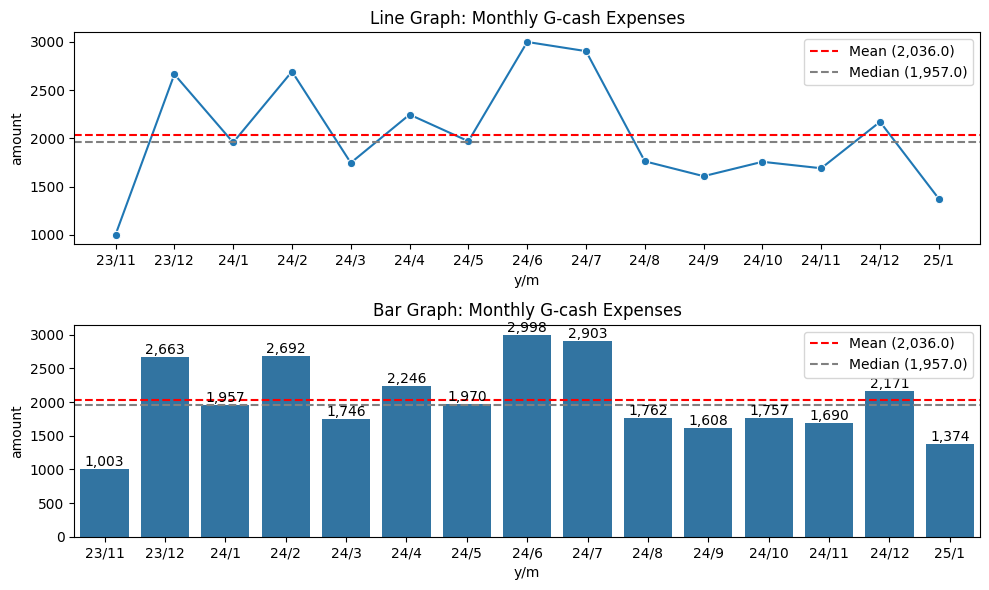

In [45]:
# Setting Summary Stat of Gcash Monthly Expenses
stats_gcash_expen = StatsSummary(gcash_monthly_expen['amount'])                     #<- Stats Summary Gcash expenses

plot_line_bar(dataset=gcash_monthly_expen,                                          #<- Line and bar plotting
              x=gcash_monthly_expen['y/m'], 
              y='amount', 
              plot_title='Monthly G-cash Expenses')

# Terminal Output
stats_gcash_expen.print_stats(round_digit=2, skew=False, kurtosis=False, mean_median_gap=False)

### Descriptive Interpretation:
- **Line Graph**
    - The mean is $\text{Php}\: 2,036$.
        - **Average monthly G-cash expenses is $\text{Php}\: 2,036$.**

    - Standard deviation is $\text{Php}\: 574$.
        - Monthly G-cash expenses may vary $\text{Php}\: 574$ either above or below the $\text{Php}\: 2,036$ on average.
        - **Monthly G-cash expenses may vary between $\text{Php}\: 1,462$ and $\text{Php}\: 2,036$ on average.**

    - **Monthly G-cash expenses from $\text{Nov.}\: 2023\: (23/11)$ to $\text{Jul.}\: 2024\: (24/7)$ are fluctuating.**
        - This means that the monthly G-cash expenses are not consistent.
        - The expenses either way more or way less than the previous expenses.

    - **Monthly G-cash expenses from $\text{Aug.}\: 2024\: (24/8)$ to $\text{Nov.}\: 2024\: (24/11)$ are stabilizing.**
        - Much more consistent monthly G-cash expenses.
        - Does not necessary less than the average, but the fluctuations are less violent.
        - **These monthly expenses are also less than the average.**

- **Bar Graph**
    - The highest monthly G-cash expenses: 
        1. $\text{Jun.}\: 2024\: (\text{24/6})$ spending $\text{Php}\: 2,998$; and 
        2. $\text{Jul.}\: 2024\: (\text{24/7})$ spending $\text{Php}\: 2,903$.

### **Monthly G-cash Expenses Distribution**

Mean = 2,036.0
Standard Deviation = 574.38
Skewness = 0.2
Kurtosis = -0.78
Mean-Median Gap = 0.04

count      15.00
mean     2036.00
std       574.38
min      1003.00
25%      1718.00
50%      1957.00
75%      2454.50
max      2998.00
Name: amount, dtype: float64


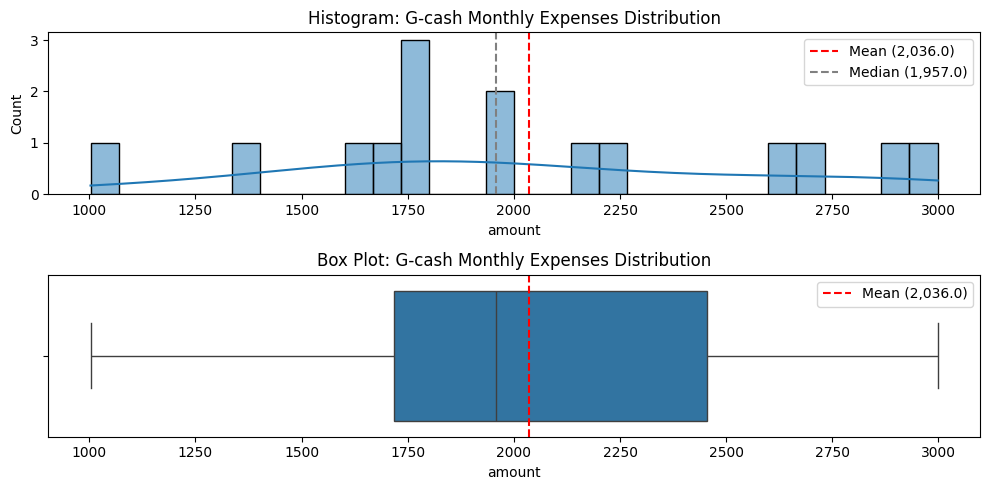

In [46]:
# Plotting Gcash Monthly Expenses Distribution
plot_distribution(data=gcash_monthly_expen['amount'], plot_title='G-cash Monthly Expenses Distribution')

# Terminal Output
stats_gcash_expen.print_stats(round_digit=2)
print(f"\n{stats_gcash_expen.stat_summary.round(2)}")

### Descriptive Interpretation:
- ⚠️**The sample size is $15$.**
    - It is less than $30$ to be safely say it forms roughly normal distribution.
        - **If the distribution is mildly skewed, this number won't help it to safely say it is normal.**

- ✅**Skewness is $0.2$.**
    - It is beyond $-0.5$ to be roughly normal, but still near it.
    - The value is between $-0.5$ and $-1$.
        - **The distribution can be considered as mildly skewed.**

- ✅**Kurtosis is $-0.78$.**
    - The tailedness of the data distribution.
    - The value is between $0$ and $1$.
        - **The distribution can be considered as light tailed.**

- ✅**Mean-median gap is $4$%.**
    - Not really a significant factor when it comes to skewness, but it gives us idea the general data distribution.
    - Reveals the general skewness of the data.
    - **$4$% means that there's less gap between mean and median.**
        - **The gap considers that the disribution is roughly normal or mildy skewed.**

- 📝**Summary Distribution Assessment:**
    - **The data distribution is roughly normal.**
    - **The mean and standard deviation are reliable for descriptive and inferential statistics.**
    - Distribution is reliable enough for parametric tests.

- **Mean is $\text{Php}\: 2,036$.**
    - **The average G-cash monthly expenses is around $\text{Php}\: 2,036$.**

- **Standard deviation is $\text{Php}\: 574.38$.**
    - The measure of variation or uncertainty of monthly expenses in G-cash.
    - **The monthly expenses in G-cash can vary approximately between $\text{Php}\: 1,461.62$ and $\text{Php}\: 2,610.38$.**

- **In Summary:**
    - The **distribution is roughly normal**.
        - The data is reliable enough for parametric tests.
    - **The average G-cash monthly expenses is around $\text{Php}\: 2,036$.**
    - **The monthly expenses in G-cash can vary approximately between $\text{Php}\: 1,461.62$ and $\text{Php}\: 2,610.38$.**

### **Inspecting Each G-cash Transaction Detail** (Monthly)
- Figuring out the behaviour of spending using e-wallet (specifically using G-cash).
- Will be split into the expenditures of each transactions made in G-cash.

In [47]:
# Grouping by Monthly Expenses Transactions
gcash_monthly_transac_expen = df_gcash_expen.groupby(['detail_clean', 'y/m'])['amount'].agg(['sum', 'mean', 'count']).reset_index()

# Aggregating Grouped by G-cash Monthly Expenses Transactions
aggr_gcash_month_trans_expen = gcash_monthly_transac_expen.groupby(['detail_clean'])['sum'].agg(['mean', 'std', 'median', 'count', 'sum']).reset_index()
aggr_gcash_month_trans_expen.round(2)

,detail_clean,mean,std,median,count,sum
0,Genshin Welkin,280.00,0.00,280.0,7,1960
1,Membership gift,258.00,NaN,258.0,1,258
2,Palaman peanut,500.00,NaN,500.0,1,500
3,Sheena,150.00,NaN,150.0,1,150
4,Spotify,236.00,11.62,239.0,15,3540
5,Steam,350.67,298.10,293.5,6,2104
6,Supa,465.27,328.97,325.0,15,6979
7,YT Membership,129.00,0.00,129.0,13,1677
8,YT sticker,15.00,NaN,15.0,1,15
9,bag,1000.00,NaN,1000.0,1,1000


#### **Appending "Others" transaction**
- Includes the transaction that have less than less than 2 count.
    - Transaction that have greater than or equal to 2 will stay as is.

In [48]:
# Setting DataFrame for Mean per Purchase Months, Monthly Total Expenses, and Expected Monthly Cost 
num_of_months = df_gcash_expen['y/m'].nunique()                                         #<- Number of Months (earliest to latest record)

others = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] < 2]        #<- Empty amount list for <1 transaction count
regulars = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] >= 2]     #<- Empty total expenses list for <1 transaction count

clean_df_gcash = regulars.loc[:, ['detail_clean', 'mean', 'sum', 'count']]              #<- Filtering "regulars" DataFrame
clean_df_gcash.sort_values(by='sum', ascending=False).round(2)

,detail_clean,mean,sum,count
6,Supa,465.27,6979,15
15,wifi load (magic data),649.12,5193,8
14,wifi load (family access),381.50,4578,12
4,Spotify,236.00,3540,15
5,Steam,350.67,2104,6
0,Genshin Welkin,280.00,1960,7
7,YT Membership,129.00,1677,13
10,buy load,706.00,1412,2


In [49]:
# Cleaning and Filtering "others"  
dict_others_gcash = others.loc[:, 'sum'].describe().to_dict()                                   #<- Setting "others" dict
df_others_gcash = pd.DataFrame([{'detail_clean': 'Others', 'mean': dict_others_gcash['mean'],   #<- Setting "others" to DataFrame
                           'sum': others['sum'].sum(), 'count': dict_others_gcash['count']}])

# Appending "others" to "regulars" Df
if df_others_gcash['detail_clean'][0] not in clean_df_gcash['detail_clean'].to_list():          #<- Avoids appending duplicate
    clean_df_gcash2 = pd.concat([clean_df_gcash, df_others_gcash], ignore_index=True)           #<- Appending "others" to "regulars"

# Terminal Output
df_others_gcash

,detail_clean,mean,sum,count
0,Others,387.125,3097,8.0


#### **The data will be aggregated into $5$ columns:** 
1. **Mean per Purchase Months**
    - Accounting the amount of each transaction, then finding the mean.
    - Mathematical expression:
        - $\frac{1}{\text{count\: of\: transactions}} \times \sum{\text{(amount\, of\, transaction)}_{i}}$
    - Does not include the months with no purchases in the computation.

2. **Total Expenses**
    - The sum of all expenses.

3. **Transaction Count**
    - Counts of monthly active transactions.
    - Monthly active transactions have at least 1 purchase of specific transaction in a month.
        - If there is at least 1 transaction, it is considered one active month purchase.
        - If there is no purchases in that particular month, that's considered inactive month purchase.
    
4. **E(monthly cost)**
    - Expected monthly cost.
    - The approximate amount where expenses approaches as number of months increases.
    - Including the months when no purchase was done (Php 0).
      
5. **Most Frequent Purchase Amount**
    - The amount of most typical purchase of a certain transaction.
    - Purchase amount may vary but this column determines what the most frequent among those variation.

### **Computing Expected Monthly Expenses (E(monthly expenses))** 

In [50]:
# Setting Df for E(monthly expenses) of each detail  
gcash_trans_details = df_gcash_expen['detail_clean'].unique().tolist()                  #<- Full list of details from g-cash transactions

expected_expen: dict = {}                                                               #<- Empty dict for E(monthly expenses)
wifi_load_df: dict = {'wifi load (magic data)':[], 'wifi load (family access)': []}     #<- Empty dict for wifi load DFs

set_date_diff = relativedelta(datetime(2023, 11, 1), datetime(2025, 2, 1))              #<- Calc'ing date difference from Jan 2025 to Nov. 2023 
date_diff = abs(set_date_diff.years * 12 + set_date_diff.months)                        #<- Date difference in months (int type)
date_list = df_gcash_expen['y/m'].unique().tolist()                                     #<- Full list of dates from g-cash transactions

for detail in gcash_trans_details:
    filtered = df_gcash_expen.loc[df_gcash_expen['detail_clean'] == detail]             #<- Filter detail by iter
    agg_filtered = filtered.groupby('y/m')['amount'].agg(['count', 'sum'])              #<- Grouping by `'y/m` then aggregating
    
    if len(agg_filtered) < len(date_list):                                              #<- Adding 0 expenses on months with no purchase
        for i in [date for date in date_list if date not in agg_filtered.index.values]:
            agg_filtered.loc[i] = [1, 0]
    
    agg_filtered['pcnt'] = agg_filtered['count'] / agg_filtered['count'].sum()          #<- Calc percentage
    agg_filtered['E(sum)'] = agg_filtered['sum'] * agg_filtered['pcnt']                 #<- Calc `'E(sum)'` column 

    if detail in wifi_load_df.keys():                                                   #<- Appeding wifi load expenses to empty dict
        for data in [filtered, agg_filtered]:
            wifi_load_df[detail].append(data)

    expected_expen[detail] = agg_filtered['E(sum)'].sum()                               #<- Appending detail to E(monthly expenses) empty dict

# Terminal Output
expected_expen

{'Spotify': 236.00000000000003,
 'Supa': 692.88,
 'YT Membership': 111.79999999999997,
 'Genshin Welkin': 130.66666666666669,
 'wifi load (magic data)': 346.2,
 'wifi load (family access)': 375.07692307692315,
 'Steam': 197.05882352941177,
 'Palaman peanut': 33.333333333333336,
 'mobile load (magic data)': 26.599999999999998,
 'Membership gift': 32.25,
 'Sheena ': 10.0,
 'welcome party aragmot': 43.333333333333336,
 'donation': 8.333333333333334,
 'bag': 66.66666666666667,
 'YT sticker': 1.0,
 'buy load': 166.11764705882354}

In [51]:
# Mapping E(monthly expenses) to "Others" DF
others['E(monthly expenses)'] = others['detail_clean'].map(expected_expen)
others

C:\Users\Acer\AppData\Local\Temp\ipykernel_20336\3467771077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others['E(monthly expenses)'] = others['detail_clean'].map(expected_expen)


,detail_clean,mean,std,median,count,sum,E(monthly expenses)
1,Membership gift,258.0,NaN,258.0,1,258,32.250000
2,Palaman peanut,500.0,NaN,500.0,1,500,33.333333
3,Sheena,150.0,NaN,150.0,1,150,10.000000
8,YT sticker,15.0,NaN,15.0,1,15,1.000000
9,bag,1000.0,NaN,1000.0,1,1000,66.666667
11,donation,125.0,NaN,125.0,1,125,8.333333
12,mobile load (magic data),399.0,NaN,399.0,1,399,26.600000
13,welcome party aragmot,650.0,NaN,650.0,1,650,43.333333


In [52]:
# Appended E(monthly expenses) to main "Others" DF
df_others_gcash['E(monthly expenses)'] = others['E(monthly expenses)'].mean()  
df_others_gcash

,detail_clean,mean,sum,count,E(monthly expenses)
0,Others,387.125,3097,8.0,27.689583


In [53]:
# Appending "Others" in E(monthly expenses) DF for Mapping
expected_expen['Others'] = df_others_gcash['E(monthly expenses)'].iloc[0]
expected_expen

{'Spotify': 236.00000000000003,
 'Supa': 692.88,
 'YT Membership': 111.79999999999997,
 'Genshin Welkin': 130.66666666666669,
 'wifi load (magic data)': 346.2,
 'wifi load (family access)': 375.07692307692315,
 'Steam': 197.05882352941177,
 'Palaman peanut': 33.333333333333336,
 'mobile load (magic data)': 26.599999999999998,
 'Membership gift': 32.25,
 'Sheena ': 10.0,
 'welcome party aragmot': 43.333333333333336,
 'donation': 8.333333333333334,
 'bag': 66.66666666666667,
 'YT sticker': 1.0,
 'buy load': 166.11764705882354,
 'Others': 27.689583333333335}

### Finalizing Table of Gcash Expenses Aggregations

In [54]:
# Renaming Columns and Appending Expected Monthly Cost
clean_df_gcash2.columns = ['details', 'mean per purchase months', 'total expenses', 'transaction count']
clean_df_gcash2['E(monthly cost)'] = clean_df_gcash2['details'].map(expected_expen)

# Appending Most Most Frequent Purchase Amount in the Df
gcash_mode_purchase = df_gcash_expen.groupby('detail_clean')['amount'].agg(lambda x: x.mode())      #<- Geting mode

gcash_expen_map = gcash_mode_purchase.to_dict()                                                     #<- Mapping dict
gcash_expen_map['buy load'] = np.median(gcash_mode_purchase['buy load'])
gcash_expen_map['Steam'] = np.median(gcash_mode_purchase['Steam'])                                  #<- Median of "Steam" mode
gcash_expen_map['Others'] = others['sum'].median()                                                  #<- Appending median "Others" transaction

clean_df_gcash2['Most Frequent Purchase Amount'] = clean_df_gcash2['details'].map(gcash_expen_map)  #<- Appending the most frequent purchase amount to Df

# Terminal Output
clean_df_gcash2.round(2)

,details,mean per purchase months,total expenses,transaction count,E(monthly cost),Most Frequent Purchase Amount
0,Genshin Welkin,280.00,1960,7.0,130.67,280.0
1,Spotify,236.00,3540,15.0,236.00,239.0
2,Steam,350.67,2104,6.0,197.06,193.5
3,Supa,465.27,6979,15.0,692.88,125.0
4,YT Membership,129.00,1677,13.0,111.80,129.0
5,buy load,706.00,1412,2.0,166.12,353.0
6,wifi load (family access),381.50,4578,12.0,375.08,199.0
7,wifi load (magic data),649.12,5193,8.0,346.20,599.0
8,Others,387.12,3097,8.0,27.69,328.5


### **Typical Active Monthly Transaction Count** (G-cash)
How many active months to considered to be ***active*** or ***less active***.

In [55]:
# Setting Summary Statistics of the Transaction Count
print('Transaction Count Summary Statistics:')
clean_df_gcash2['transaction count'].describe().round(2)

Transaction Count Summary Statistics:


count     9.00
mean      9.56
std       4.45
min       2.00
25%       7.00
50%       8.00
75%      13.00
max      15.00
Name: transaction count, dtype: float64

### Descriptive Interpretation:
- $50$% percentile is $8$ transaction counts.
    - **We can say that the typical active monthly transaction is greater than or equal to $8$ counts.**
        - These count can be considered as **active**.
        - This will be helpful for referencing on comparing each expenses transaction later.
    - If transaction count is less than $8$, they can be considered as **less active**.

### **Data Visualization of Every G-cash Expenses Details**
Shows bar graph to compare each transactions.

Total Number of Months Recorded = 15 Months


,detail_clean,Most Frequent Purchase Amount
0,Genshin Welkin,280
1,Membership gift,129
2,Palaman peanut,500
3,Sheena,150
4,Spotify,239
5,Steam,"[34, 92, 144, 188, 199, 280, 399, 768]"
6,Supa,125
7,YT Membership,129
8,YT sticker,15
9,bag,1000


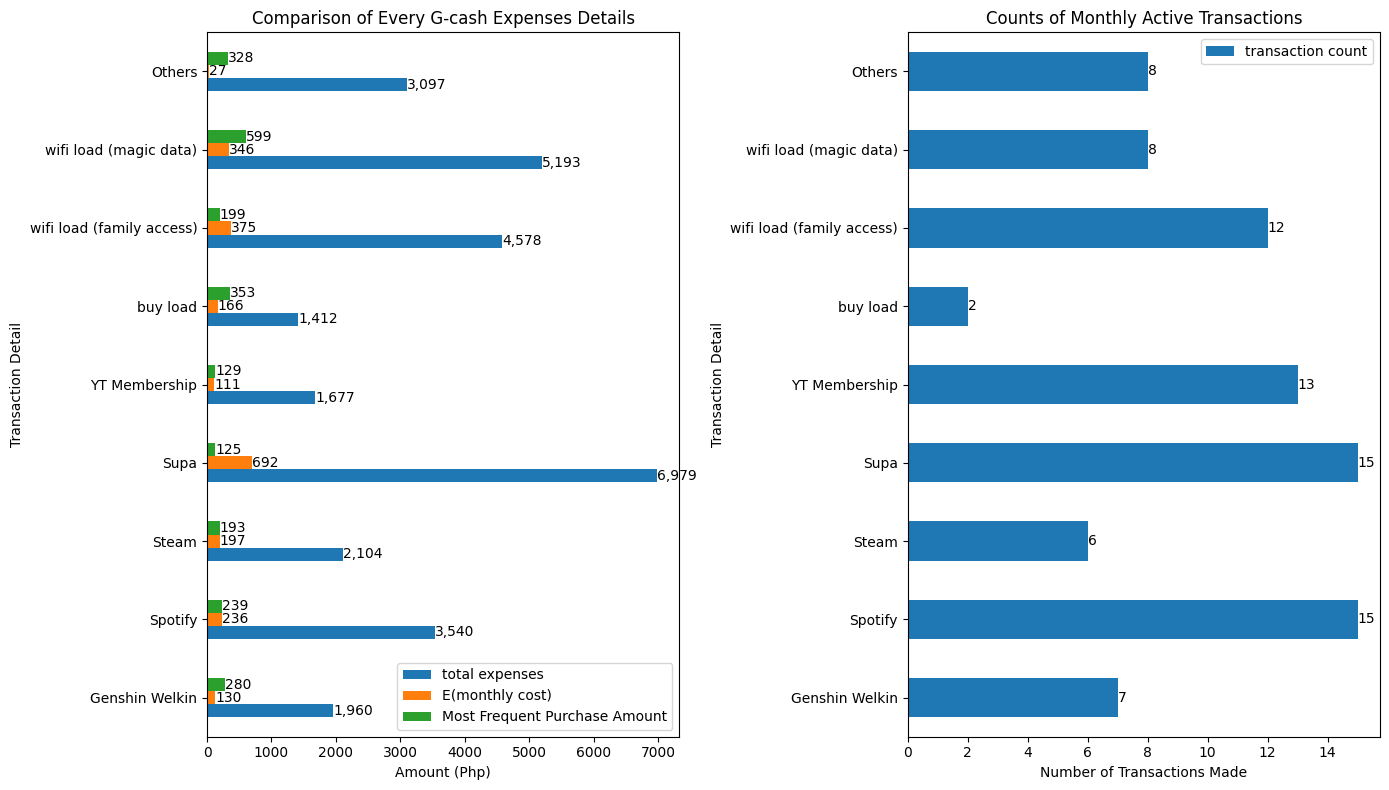

In [56]:
# Data Visualization for Mean per Purchase Months, Total Expenses, and Expected Monthly Cost
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Horizontal Bar Plot of Mean per Purchase Months and Expected Monthly Cost
ax0 = clean_df_gcash2.plot(kind='barh', x='details', 
                           y=['total expenses', 'E(monthly cost)', 'Most Frequent Purchase Amount'], 
                           ax=ax[0])
for bar in ax0.patches:
    width = bar.get_width()
    ax0.text(x=width, y=bar.get_y() + (bar.get_height()/2), s=f'{int(width):,}', va='center', ha='left')
ax0.set_xlabel('Amount (Php)')
ax0.set_ylabel('Transaction Detail')
ax0.set_title('Comparison of Every G-cash Expenses Details')

# Horizontal Bar Plot of Expected Monthly Cost
ax1 = clean_df_gcash2.plot(kind='barh', x='details', y='transaction count', ax=ax[1])
for bar in ax1.patches:
    width = bar.get_width()
    ax1.text(x=width, y=bar.get_y() + (bar.get_height()/2), s=f'{int(width):,}', va='center', ha='left')
ax1.set_xlabel('Number of Transactions Made')
ax1.set_ylabel('Transaction Detail')
ax1.set_title('Counts of Monthly Active Transactions')

plt.tight_layout()

# Terminal Output
print(f"Total Number of Months Recorded = {num_of_months} Months")

gcash_mode_purchase.loc['Others'] = others['sum'].to_list()                                 #<- Appending "Others" to the mode purchase Df
gcash_mode_purchase.rename('Most Frequent Purchase Amount').reset_index()                   #<- Showing the full detail of most frequent purchases amount

### Descriptive Interpretation:
- **NOTE:**
    - **On the table, there are details that have more than 1 values** of most frequent purchases amount.
        - It means there are more than 1 that have the same frequency of occuring.
    - To determine the most frequent among these values, **the analyst used their median value of these most frequent purchase amount.**

- **"*Supa*" transaction:**
    - **Total expenses is $\text{Php}\: 6,979$.**
        - Highest total expenses among G-cash transactions.
    - **Counts of monthly active transaction is $15$.**
        - **One of the highest transaction made in each month.**
        - Might be the reason why it is the highest total expenses because there were too many transactions made.
    - **Its mean per purchase months is $\text{Php}\: 465.27$.**
        - This means that in every month that I purchase this at least once, it averages about $\text{Php}\: 465.27$ expenditure.
    - **Most frequent purchase amount is $\text{Php}\: 125$.**
        - The least among the transactions.
        - This means that for every purchases, I often buy this with a price of $\text{Php}\: 125$.
        - The least single buy among the transactions.
    - **Expected monthly cost is $\text{Php}\: 692$.**
        - The highest among the transactions.
        - This means that as the number of months increases while spending things, **"*Supa*"** will have an approximate monthly cost of $\text{Php}\: 692$.
    - Despite being the highest total expenses and the most active monthly transaction, it has the least purchase amount.
    - But the expected monthly cost signals, that out of all transactions, this might be one I spend the most in each month despite its small amount each time I buy it.

- **"*Wifi load (magic data)*" vs. "*Wifi load (family access)*" transactions:**
    - **Most frequent purchase amount: $\text{Php}\: 599$ vs. $\text{Php}\: 199$.**
        - **"*Wifi load (family access)*" is definitely less** in single purchase.
    
    - **Expected monthly cost:**
        - Tells about the value of monthly cost approaches as number of months increases.
        - **"*Wifi load (magic data)*" is $\text{Php}\: 346.2$.**
        - **"*Wifi load (family access)*" is $\text{Php}\: 375$.**
        - "*Wifi load (magic data)*" is lesser.
            - This means that "*Wifi load (magic data)*" expenses in upcoming months will be around $\text{Php}\: 346.2$.
            - It is lower because there were no more purchases in later months.
        - This means as the month passes, the monthly expenses of "*Wifi load (family access)*" will be around $\text{Php}\: 346.2$, in both cases that I may buy or I may not in a certain month.
            - The same case of "*Wifi load (family access)*", but the expected monthly expenses would be $\text{Php}\: 375$.

        - **Inspecting the expected value of monthly expenses of these wifi load plans will reveal which wifi data plan is wise to buy overtime.**
            - Assumption that each of them have same number of months and purchasing at least once per month will lessen bias and have more reliable calculation.

    - **Total expenses: $\text{Php}\: 5,193$ vs. $\text{Php}\: 4,578$.**
        - "*Wifi load (family access)*" is lesser.

    - **Counts of monthly active transactions: $8$ vs. $12$.**
        - Talks about how many months the transaction have of at least one purchase in a month.
        - "*Wifi load (family access)*" is greater.
            - This means that there are more active buying months than "*Wifi load (magic data)*".
            
    - Despite having more monthly active transaction counts, total expenses of "*Wifi load (family access)*" is lesser.
    - **In general, "*Wifi load (family access)*" spends less in most ways** than "*Wifi load (magic data)*".
    - Inspecting the expected value of these wifi load plans while assuming they have equal monthly active transaction (to avoid bias) will help us decide which is better purchase.

- **In Summary:**
    - "*Supa*" may have the least amount per purchase, but it has the highest per month purchase.
        - **Minding this expenditure behaviour will help lessen the total monthly expenses in G-cash.**
    - **"*Wifi load (family access)*" seems to be less expensive overtime than "*Wifi load (magic data)*".**
        - Analyzing their expected monthly expenses could give us more certain information to decide.

### **Calculating Expected Value of Monthly Expenses of Each Wifi Load**
This will determine which wifi load expends less overtime.
    - Enables us to decide which purchase spends less

In [57]:
# Calculating the Expected Value of Each Wifi Load
expec_wifi_load: dict = {}                                                  #<- Empty dict for E(wifi load)
load_name = {'wifi load (magic data)': 'Magic Data',                        #<- Renames the wifi load name
             'wifi load (family access)': 'Family Access'}

for key, data in wifi_load_df.items():
    mode = data[0]['amount'].value_counts().index[0]                        #<- Most frequent value
    filtered = data[0]                                                      #<- Filtered data
    agg_filtered = data[1]                                                  #<- Aggregated filtered data
    
    for idx, row in agg_filtered.iterrows():                                #<- Changing no purchased months with the mode value
        if row['sum'] < 1:
            agg_filtered.loc[idx, 'sum'] = mode

    agg_filtered['E(sum)'] = agg_filtered['sum'] * agg_filtered['pcnt']     #<- Recalculating the indiv. expected value                        
    expec_wifi_load[load_name[key]] = agg_filtered['E(sum)'].sum()          #<- Appending expected value of wifi load to the empty dict

# Terminal Output
print('E(monthly expenses) of Each Wifi Load:')

for key, val in expec_wifi_load.items():
    print(f" - {key} = Php {val:,.2f}")
    print(f"    - In next 12 months = Php {val * 12:,.2f}\n")

E(monthly expenses) of Each Wifi Load:
 - Magic Data = Php 625.73
    - In next 12 months = Php 7,508.80

 - Family Access = Php 398.04
    - In next 12 months = Php 4,776.46



### Interpretation:
- Expected value tells us the average amount of something as the number of trials of it increases.
- In the records, both have the same number of months of $15$.
    - Each have at least 1 purchase of per month.
    - If 0 purchase in a month, substituted it with the most frequent single purchase.
    - This assumes that at least 1 purchase was done to avoid bias.

- Family Access have $\text{Php}\: 398.04$ expected monthly expenses.
    - This means that the average monthly expenses is $\text{Php}\: 398.04$.
    - This is the least among the two wifi load.
    - After $12$ months, it has expected value around $\text{Php}\: 4,776.46$.
        - This means that after $12$ months, this wifi load spends around $\text{Php}\: 4,776.46$.
        - Much smaller than *Magic Data* load.
    - **It is safe to say that Family Access spends less overtime than Magic Data.**
        - Subscribing Family Access load spends less overtime.

- **In Summary:**
    - **Buying Family Access load for wifi spends less overtime.**

### **Average Number of Montly Purchase**
About how many times a transaction is purchased per month on average.

Text(0.5, 1.0, 'Average Number of Monthly Purchases')

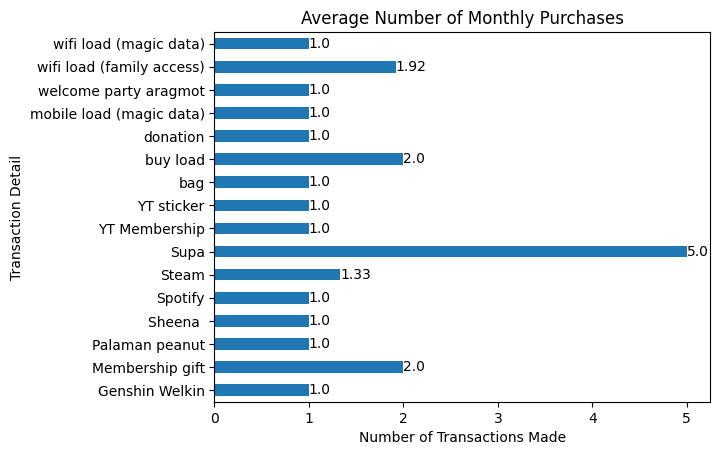

In [58]:
# Setting DF for Average Number of Monthly Purchase
ave_monthly_transaction = {}                                                            #<- Empty dict for average monthly transaction

for detail in gcash_monthly_transac_expen['detail_clean'].unique():                     #<- Getting average number of monthly purchase of each transaction
    ave_monthly_transaction[detail] = gcash_monthly_transac_expen[gcash_monthly_transac_expen['detail_clean'] == detail]['count'].mean().round(2)

# Plotting the Average Number of Monthly Purchases
plot = pd.Series(ave_monthly_transaction).plot(kind='barh')                             #<- Bar plot of average number of monthly purchases

for bar in plot.patches:                                                                #<- Data label for each bar
    width = bar.get_width()
    plot.text(x=width, 
              y=bar.get_y() + (bar.get_height()/2), 
              s=f'{width.round(2)}', 
              va='center', 
              ha='left')
    
plot.set_xlabel('Number of Transactions Made')                                          #<- x-label
plot.set_ylabel('Transaction Detail')                                                   #<- y-label
plot.set_title('Average Number of Monthly Purchases')                                   #<- Graph title

### Descriptive Interpretation:
- **"*Supa*" is purchased $5$ times on average.**
    - The highest number of single purchases per month.
- **"*wifi load (family access)*" is bought $1.92$ times per month on average.**
    - Buys approximately 2 times each month.
    - This proves further that even though this wifi load is purchased almost twice a month, it still have lesser expected monthly expenses.

### **G-cash Monthly Expenses Moving Averages Smoothing**
- Trend detection of G-cash monthly expenses.
- Analyzing monthly spending behavior in G-cash. 

Median = 17,583.000
G-cash Expenses Mean = 2,036
Proportion of Total G-cash Expenses from Total Expenses = 12%
Moving Average Diff. Mean = -29

G-cash Expenses from Mar. 2024 to Oct. 2024:
- Moving Average Diff. Mean = 28

G-cash Expenses from Oct. 2024 and Onwards:
- Moving Average Diff. Mean = -132

Last Two Months of G-cash Monthly Expenses:
- Previous Month = 2,171
- Latest Month = 1,374

- Growth Rate = -37% (-797)
- Distance from Mean (Latest Month) = -662 (-33%)
- Std away from mean (Latest month) = -1.15


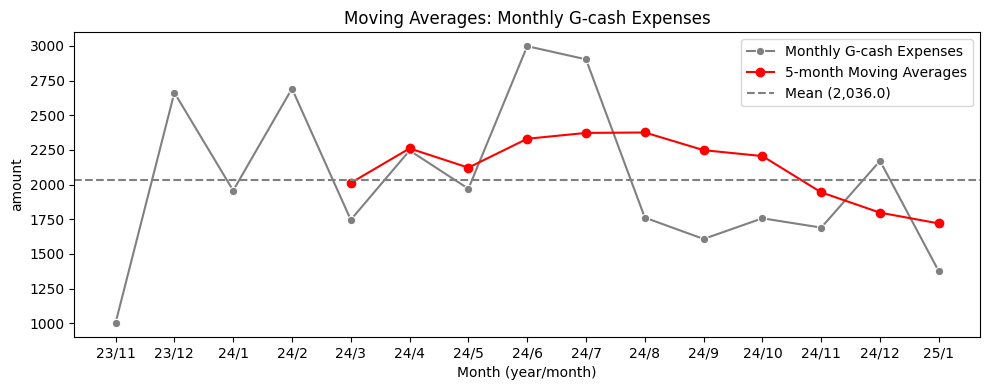

In [70]:
gcash_expen_move_ave = moving_ave_smoothing(x_data=gcash_monthly_expen['y/m'],               #<- Moving averages plotting of G-cash monthly expenses
                              y_data=gcash_monthly_expen['amount'],
                              plot_title='Moving Averages: Monthly G-cash Expenses',
                              plot_label='Monthly G-cash Expenses',
                              smoot_label='5-month Moving Averages',
                              x_label='Month (year/month)',
                              hline_val='mean')

# Setting G-cash Monthly Expenses Trend Analysis
median_expen_by_month = stats_monthly_expen.median

gcash_monthly_expen_2 = gcash_monthly_expen.copy()                                          #<- Copying DataFrame of monthly expneses
gcash_monthly_expen_2['date'] = gcash_monthly_expen_2['y/m'].map(convert_to_datetime(gcash_monthly_expen_2['y/m']))
gcash_monthly_expen_2['mov ave'] = gcash_expen_move_ave[1]
gcash_monthly_expen_2['mov ave diff'] = gcash_monthly_expen_2['mov ave'].diff()

total_gcash_expen = gcash_monthly_expen_2['amount'].sum()
gcash_expen_mean = gcash_monthly_expen_2['amount'].mean()

print(f"Median = {median_expen_by_month:,.3f}")
print(f"G-cash Expenses Mean = {gcash_expen_mean:,.0f}")
print(f"Proportion of Total G-cash Expenses from Total Expenses = {total_gcash_expen/total_expenses * 100:.0f}%")
print(f"Moving Average Diff. Mean = {gcash_monthly_expen_2['mov ave diff'].dropna().mean():,.0f}")

# G-cash Expenses from Mar. 2024 to Oct. 2024
gcash_expen_mar24_to_oct24 = gcash_monthly_expen_2[(gcash_monthly_expen_2['date'] >= '2024-03-01') & (gcash_monthly_expen_2['date'] <= '2024-10-01')]

print(f"\nG-cash Expenses from Mar. 2024 to Oct. 2024:")
print(f"- Moving Average Diff. Mean = {gcash_expen_mar24_to_oct24['mov ave diff'].dropna().mean():.0f}")

# G-cash Expenses from Oct. 2024 and Onwards:
gcash_expen_gt_oct24 = gcash_monthly_expen_2[gcash_monthly_expen_2['date'] >= '2024-10-01']

print(f"\nG-cash Expenses from Oct. 2024 and Onwards:")
print(f"- Moving Average Diff. Mean = {gcash_expen_gt_oct24['mov ave diff'].mean():.0f}")

# Last Two Months of Monthly G-cash Expenses
last_two_months: pd.Series = gcash_monthly_expen_2.iloc[-2:]['amount']
last_two_months_diff: np.float64 = last_two_months.diff().iloc[-1]
latest_month_median_diff = last_two_months.iloc[1] - gcash_expen_mean

latest_month_zscore = mad_based_z(last_two_months.iloc[1], gcash_monthly_expen_2['amount'].mean(), gcash_monthly_expen_2['amount'].std(ddof=1))

print('\nLast Two Months of G-cash Monthly Expenses:')
print(f"- Previous Month = {last_two_months.iloc[0]:,.0f}")
print(f"- Latest Month = {last_two_months.iloc[1]:,.0f}")

print(f"\n- Growth Rate = {last_two_months_diff/last_two_months.iloc[0] * 100:.0f}% ({last_two_months_diff:.0f})")
print(f"- Distance from Mean (Latest Month) = {latest_month_median_diff:,.0f} ({latest_month_median_diff / gcash_expen_mean * 100:,.0f}%)")
print(f"- Std away from mean (Latest month) = {latest_month_zscore:,.2f}")

### Descriptive Interpretation:
- **Note:**
    - Mean is used as the standard comparison as the data distribution is roughly normal.

- **$12$% of the total expenses is coming from G-cash.**

- **The trend of moving averages (red line) is dropping.**
    - The rolling average is dropping by $\text{Php}\: 29$ on average.
    - G-cash monthly expenses is decreasing, especially in earlier months.

- **G-cash Monthly Expenses from $\text{Mar.}\: 2024$ to $\text{Oct.}\: 2024$ is slightly increasing.**
    - Rolling averages is sligthly increasing by $\text{Php}\: 28$.

- **G-cash Monthly Expenses from $\text{Oct.}\: 2024$ and onwards is declining.**
    - Rolling averages is decreasing by $\text{Php}\: 132$.
    - Declination is caused by focusing less on digital transactions.

- **For the last two months, the growth rate is declining about $37$%.**
    - Monthly expenses in G-cash is dropping about $\text{Php}\: 797$ on average.
    - From $\text{Php}\: 2,171$ in $\text{Dec.}\: 2024$, to $\text{Php}\: 1,374$ in $\text{Jan.}\: 2025$
    - The latest month's expense is $33$% below the mean, having $\text{Php}\: 662$ difference.
    - The latest month's expense is $1.15$ standard deviation away from the mean.
        - The declination rate is reasonable enough. Not unsual, and not that definite or typical either.

- **In Summary:**
    - **$12$% of the total expenses is coming from G-cash.**
    - In general, the trend of monthly expenses in G-cash is declining.
    - **G-cash Monthly Expenses from $\text{Oct.}\: 2024$ and onwards is declining by $\text{Php}\: 132$ on average (5-month rolling averages).**
    - **For the last two months, the growth rate is declining about $37$%.**
        - That's $33$% below the mean, having $\text{Php}\: 662$ difference.
        - The declination rate is still reasonable. Not unsual, and not that definite or typical either.

# **Hypothesis Testing**
## **Question 1:**  
#### The median of the monthly income is approximately $\text{Php}\: 30,000$. If the monthly expenses reaches over $60$% of this $(\text{Php}\: 18,000)$, it is considerable enough that expenditures during that month is more than necessary. **Does the data suggest that I am spending more than necessary?**

### Double Checking the Montly Expenses Data Distribution
Sanity checks on the distribution first before taking action.

Mean = 17,458.33
Standard Deviation = 6,540.11
Skewness = 0.57
Kurtosis = -0.42
Mean-Median Gap = 0.01


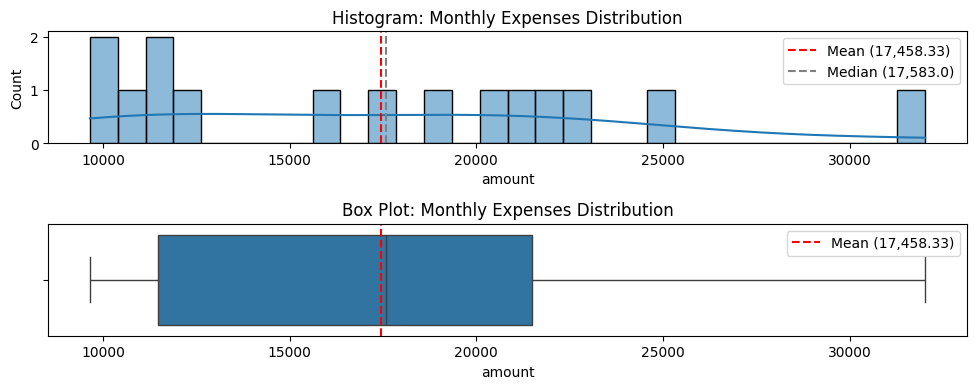

In [60]:
# Distribution Check with Distribution Plot
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution', fig_size=(10, 4))

# Terminal Output
stats_monthly_expen.print_stats(round_digit=2)

### Data Distribution Summary:
- **The distribution is mildly skewed.**
    - Skewness suggest mildly skewed.
    - Kurtosis supports the mild skew of the distribution as it shows light tailedness.
    - Mean-median gap are too close.
    - Using parametric tests in this data may be shaky and not ideal, but can still be utilized for inferences and hypothesis testing.

- **Monthly expenses is around $\text{Php}\: 17,458$ on average.**

- **Monthly expenses may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**

### The Condition of Independence and Randomness of the Data
- Necessary **to further verify if the condition is right for parametric test** on the sample. 
- This can be verified altogether using *`pd.plotting.autocorrelation_plot()`*.
    - The plot tests whether the data values are correlated with their own past.
        - If favorably verified, **data points are independent** from the previous data point.
        - If they each data point is indpendent, then they **can also be considered as randomly sampled**.

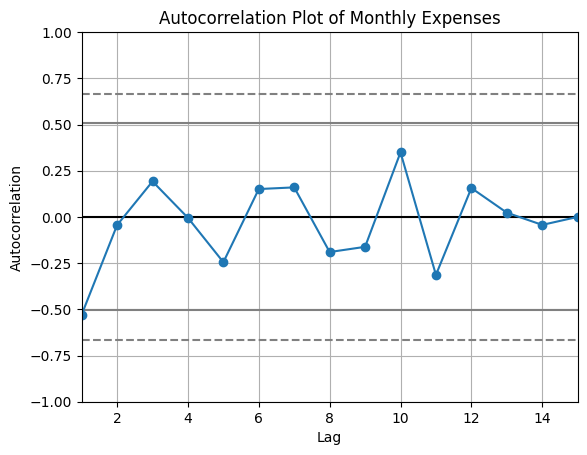

In [61]:
# Checking Autocorrelation plot of Monthly Expenses
hyptest_grpby_expen_by_month = HypothesisTest(data=grpby_expen_by_month['amount'], null_value=18_000, alpha=0.1)
hyptest_grpby_expen_by_month.check_autocorrelation_plot('Monthly Expenses')

### Interpretation:
✅**Independence:**
- Most data points are contained approximately inside $\pm\; 0.70$.
- **Data points are independent** to prior data point.

✅**Randomness:**
- Data are independent in the plot.
- Randomness seems **statistically valid and justified**.

### Parametric Hypothesis Testing will be used.
- The monthly expenses data is **mildly skewed**.
- **1-sample t test** could be the best tool for testing the hypothesis. 

### Hypotheses Definition:
$H_0: \mu = \text{Php}\: 18,000$  
    - The data tells that it is **NOT necessarily spending more than needed.**

$H_A: \mu > \text{Php}\: 18,000$   
    - The data tells that it is **spending more than needed.**

$\alpha = 0.1$   
    - Significance level.    
    - Increasing the likelihood to reject null hypothesis for safety net.    
    - *It is better to reject null hypothesis even if it's true to reduce the risk of too much spending than necessary.*

In [62]:
# Non-parametric Hypothesis Testing
_, pvalue = hyptest_grpby_expen_by_month.ttest_1sample(alternative='greater')

# Terminal Output
print(f'p-value: {pvalue:.4f}\n')                                              #<- p-value

print(f'Result:')
interp_pvalue(p_value=pvalue, alpha=0.1)                                       #<- alpha vs. p-value

p-value: 0.6234

Result:
Fail to Reject Null Hypothesis (p-value > alpha).


### Interpretation:
- Fail to reject null hypothesis.
- There's **NOT enough evidence** to conclude that there are more expenditures than necessary.
- **The data suggests that monthly expenditures are not necessarily more than necessary.**

## **Question 2:** 
##### When I started teaching, I have approximately $\text{Php}\: 21,000$ monthly salary (incentives not included). **Does that amount is now significantly less if I add up most incentives and after some changes of teacher's monthly salary from the start of my teaching career up until now?**

### Data Distribution Check on the Monthly Income Distribution
Sanity checks first on the data distribution.

Mean = 36,427.47
Standard Deviation = 14,692.16
Median = 30,278.0
MAD = 5,083.0
Skewness = 0.89
Kurtosis = -0.27
Mean-Median Gap = 0.17
Sample size = 17


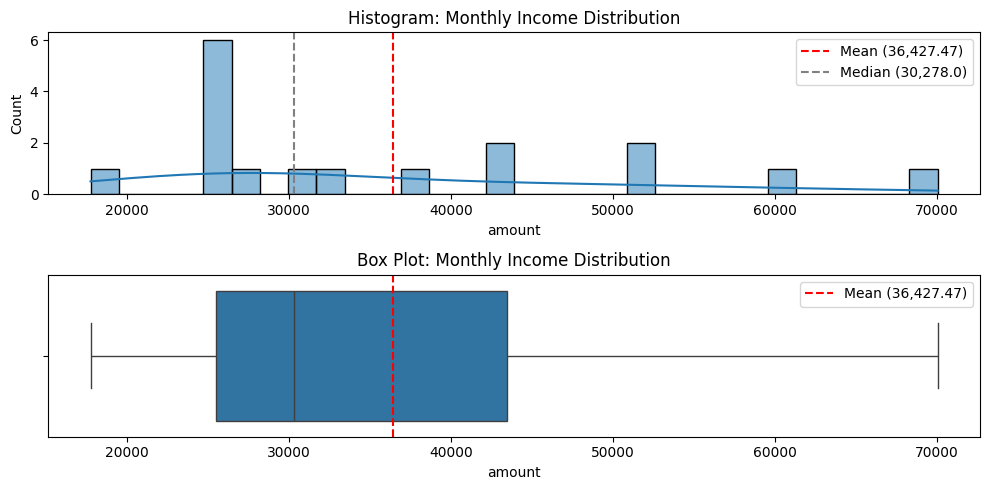

In [63]:
# Distribution Plot for Monlthy Income 
plot_distribution(data=stats_monthly_income.data, plot_title='Monthly Income Distribution')  #<- Plotting Monthly Income Distribution

# Terminal Output
stats_monthly_income.print_stats(median=True, mad=True, round_digit=2)
print(f'Sample size = {len(stats_monthly_income.data)}')

### Data Distribution Summary:
- **The distribution is positively skewed.**
    - Skewness suggests skewness to the right.
    - Kurtosis suggests slightly light tailed.
    - Mean-median gap is far enough to generally tell that it is skewed.
    - The sample size also contributes more that it approaches to not normal yet.

- **The middle value of monthly income is $\text{Php}\: 30,278$.**

- **Monthly income varies from $\text{Php}\: 25,195$ to $\text{Php}\: 35,361$ around the median.**

### Non Parametric Test will be Used.
- The monthly income distributed is **skewed to the right**.
- **1-sample Wilcoxon Signed-Rank Test** is suitable for testing the hypothesis.

### Hypotheses Definition:
$H_0: \text{Median} = \text{Php}\: 21,000$    
    - The data suggests that $\text{Php}\: 21,000$ is **NOT significantly less after overall salary changes**.  

$H_A: \text{Median} < \text{Php}\: 21,000$    
    - The data suggests that $\text{Php}\: 21,000$ is **significantly less after overall salary changes**.

$\alpha = 0.05$    
    - Significance level.

In [64]:
# Hypothesis Testing Question 2 with Wilcoxon Signed-Rank Test
monthly_income_hyptest = HypothesisTest(data=stats_monthly_income.data, null_value=21_000)
_, pvalue = monthly_income_hyptest.wilcoxon_test(alternative='less')

# Terminal Output
print(f'p-value = {pvalue:.4f}')

print('\nResult:')
interp_pvalue(p_value=pvalue)

p-value = 0.9998

Result:
Fail to Reject Null Hypothesis (p-value > alpha).


### Interpretation:
- Fail to reject null hypothesis.
- **Data suggests that $\text{Php}\: 21,000$ is NOT significantly less after overall salary changes**.
- There's **NOT enough evidence** to conclude that $\text{Php}\: 21,000$ is significantly less after overall salary changes.

# **Overall Findings**
- **Key Performance Indicator (KPI)**
    - **Expenses ratio is $42.29$%.**
        - It is **below of target standard of $60$% which means it's way below from the warning signs** to be wary about in spending behavior.

    - **Net income ratio is $57.71$%.**
        - The percentage of total remaining income after all the spending.
        - **$57.71$% is very high from usual recommendation of $20$%** in personal financing.
            - The remaining money can be either keep to savings or be invested.

- **Net Income**
    - **The typical monthly net income is around $\text{Php}\: 15,819$**.
        - The target amount is $\text{Php}\: 6,446$ (from $20$% of monthly income).
        - Typical monthly net income is **$\text{Php}\: 9,373$ higher than the target amount**.

    - Monthly net income despersion are typically $\text{Php}\: 10,999$ away from the median on average.

    - **The typical $50$% of monthly net income data is between $\text{Php}\: 7,009.5$ and $\text{Php}\: 30,168$.**
    - The ***net income ratio*** from the last two months is $44$% $(\text{Php}\: 34,204)$.
        - This is two times higher than the target $20$%

    - **Trend of Net Income:**
        - **The trend of monthly net income, in general, is increasing since August 2024.**

        - From the last two months, the **growth rate is dropping by $81$%** .
            - This drop is **caused by the christmas and new years seasonal expenditure, and by the large income of incentives received.**

        - Despite the huge drop rate, **the average net income for the last two months is still higher than its target amount by $24$%.**
        
        - ***Consider to be cautious*** since the latest month, **$\text{Jan.}\: 2025$, is $\text{Php}\: 1,053$ lower than the target amount.**

- **Monthly Expenses Transaction**
    - The mean monthly expenses is $\text{Php}\: 17,458.33$.
    - On average, the data varation is $\text{Php}\: 6,540$ around the mean.

    - The **highest monthly expenses is in $\text{Dec.}\: 2023\: \text{(23/12)}$, reaching $\text{Php}\: 32,023$.**
        - Comparing this against average monthly expenses, **there are $\text{Php}\: 14,540.11$ or $45.48$% difference.**
        - The reason why it is the highest **because of laptop repairs and upgrade expenses** on the top of monthly necessities.
    
    - **Trend of Monthly Expenses**
        - **Monthly expenses is increasing.**
            - 5-month rolling averages shows that it increases about $\text{Php}\: 72.5$ on average.
        
        - For the last two months, monthly expenses dropped by $7$% from $\text{Dec.}\: 2024$ to $\text{Jan.}\: 2025$.
            - Despite the drop, **the average expenses of these months is $24$% above from the median.**
        - Spike of monthly expenses is caused by Christmas and New Years season-related purchases.
        - The Christmas and New Years season-related expenses of $\text{2024-2025}$ (the recent season) is higher than the same season in year $\text{2023-2024}$ (the previous season).
        
    - **There's $95$% confidence that the true average monthly expenses is between around $\text{Php}\: 14,400$ and around $\text{Php}\: 20,700$.**

    - In *hypothesis testing*, **the data suggests that monthly expenditures are not spending more than necessary** (assuming that people spends $\text{Php}\: 18,000$ on average).

- **Daily Expenses**
    - The typical daily expenses is $\text{Php}\: 239$.
    - **Daily expenses may vary on average of $\text{Php}\: 157$ either below or above $\text{Php}\: 239$.**
    - **The middle $50$% is between $\text{Php}\: 125$ and $\text{Php}\: 691$.**
    - The distribution is skewed to the right with many large outliers.

- **Monthly Income**
    - **Nov. 2023, Nov. 2024** and **Dec. of 2024** have the highest income.
        - These are **caused by the months when incentives and other income sources comes**.
        - Seasonal income comes in these months.

    - **The middle value of monthly income is $\text{Php}\: 30,278$.**
    - **Monthly income varies $\text{Php}\: 5,083$ on average around the median.**

    - The **typical middle $50$% proportion of monthly income is between $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**

    - **Trend of Monthly Income:**
        - **Monthly income is increasing**, showed by rolling averages with $\text{Php}\: 362$ average increase.

        - Monthly income has been **increasing by $\text{Php}\: 293$ on average since $\text{Apr.}\: 2024\: (24/04)$ and onwards.**

        - **The growth rate is dropping by $49$% from the last two months.**
            - The huge drop stems from high unusual seasonal income, to lower usual income.
            - **The drop rate is basically a "return to normal" rate after a huge seasonal income from previous month.**

    - In *hypothesis testing*, **the data suggests that $\text{Php}\: 21,000$ income is NOT significantly less after overall salary changes**.
        - $\text{Php}\: 21,000$ is the starting salary of public teacher in 2021.  

- **G-cash Transactions**
    - **The mean G-cash monthly expenses is around $\text{Php}\: 2,036$.**
    - **These expenses spread about $\text{Php}\: 574$ on average from the mean.**
    - **$12$% of the total expenses is coming from G-cash.**

    - The "*Supa*" transaction may have the least amount per purchase, but it has the highest per month purchase.
        - **Minding this expenditure behaviour will help lessen the total monthly expenses in G-cash.**
        - **Among G-cash expenses, it is purchased 5 times per month.**
            - The highest monthly purchasing frequency among the expenses.

    - "*Wifi load (family access)*" is better purchase than "*Wifi load (magic data)*" in terms of total expenses overtime.

    - **Trend of G-cash Monthly Expenses:**
        - In general, the trend of monthly expenses in G-cash is declining.
        - **G-cash Monthly Expenses from $\text{Oct.}\: 2024$ and onwards is declining by $\text{Php}\: 132$ on average (5-month rolling averages).**
        - **For the last two months, the growth rate is declining about $37$%.**
            - That's $33$% below the mean, having $\text{Php}\: 662$ difference.
            - The declination rate is still reasonable. Not unsual, and not that definite or typical either.